# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

#### Импорт необходимых библиотек

In [1]:
!pip install shap
!pip install phik
!pip install optuna
!pip install optuna-integration

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from phik import phik_matrix

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [4]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', delimiter=';', decimal=',')
except Exception:
    print('Что-то пошло не так...\nПроверьте наличие данных')

#### Проведем краткий обзор каждого dataframe

##### market_file

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

##### market_money

In [7]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


##### market_time

In [9]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


##### money

In [11]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


#### Выводы
Был проведен обзор данных, где **не было** выявлено некоторого кол-ва пропусков, что делает данные приятными для работы. В **dataframe** money была проведена обработка признака **Прибыль** и приведение его к корректному виду.
Данные в таблицах соответствуют описанию.

## Предобработка данных

#### market_file

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [14]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Необходимо проверить категориальные признаки на предмет неявных дубликатов, а именно: **Покупательская активность**, **Тип сервиса**, **Разрешить сообщать**, **Популярная_категория**.

In [15]:
print(f'Покупательская активность: {market_file["Покупательская активность"].unique()}\n')
print(f'Тип сервиса: {market_file["Тип сервиса"].unique()}\n')
print(f'Разрешить сообщать: {market_file["Разрешить сообщать"].unique()}\n')
print(f'Популярная_категория: {market_file["Популярная_категория"].unique()}\n')

Покупательская активность: ['Снизилась' 'Прежний уровень']

Тип сервиса: ['премиум' 'стандартт' 'стандарт']

Разрешить сообщать: ['да' 'нет']

Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



Исправим в признаке **Тип сервиса** `стандратт` на `стандарт`

In [16]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].apply(lambda x:'стандарт' if x == 'стандартт' else x)
print(f'Покупательская активность: {market_file["Покупательская активность"].unique()}\n')
print(f'Тип сервиса: {market_file["Тип сервиса"].unique()}\n')
print(f'Разрешить сообщать: {market_file["Разрешить сообщать"].unique()}\n')
print(f'Популярная_категория: {market_file["Популярная_категория"].unique()}\n')

Покупательская активность: ['Снизилась' 'Прежний уровень']

Тип сервиса: ['премиум' 'стандарт']

Разрешить сообщать: ['да' 'нет']

Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



Также проверим на наличие явных дубликатов:

In [17]:
print(f'Before deleting duplicates: {market_file.shape}')
market_file.drop_duplicates(inplace=True)
print(f'After deleting duplicates: {market_file.shape}')

Before deleting duplicates: (1300, 13)
After deleting duplicates: (1300, 13)


Явных дубликатов не было выявлено.

Теперь приведем название признаков к более корректному виду:

In [18]:
market_file.columns = market_file.columns.str.lower().str.replace(' ', '_')
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

#### market_money

In [19]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [20]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Далее в предобработке не будут описаны поэтапно шаги, так как они будут соответствовать пункту 2.1. Если будет что-то не по этому пункту, то появятся соответствующие комментарии.

In [21]:
print(f'Уникальные значения признака Период: {market_money.Период.unique()}\n')
market_money.columns = market_money.columns.str.lower()
print(f'Название признаков после приведения их к нижнему регистру: {market_money.columns}\n')
print(f'Before deleting duplicates: {market_money.shape}')
market_money.drop_duplicates(inplace=True)
print(f'After deleting duplicates: {market_money.shape}')

Уникальные значения признака Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Название признаков после приведения их к нижнему регистру: Index(['id', 'период', 'выручка'], dtype='object')

Before deleting duplicates: (3900, 3)
After deleting duplicates: (3900, 3)


#### market_time

In [22]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [23]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [24]:
print(f'Уникальные значения признака Период: {market_time.Период.unique()}\n')
market_time['Период'] = market_time.Период.apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)
print(f'Уникальные значения признака Период после корректировки: {market_time.Период.unique()}\n')
market_time.columns = market_time.columns.str.lower()
print(f'Название признаков после приведения их к нижнему регистру: {market_time.columns}\n')
print(f'Before deleting duplicates: {market_time.shape}')
market_time.drop_duplicates(inplace=True)
print(f'After deleting duplicates: {market_time.shape}')

Уникальные значения признака Период: ['текущий_месяц' 'предыдцщий_месяц']

Уникальные значения признака Период после корректировки: ['текущий_месяц' 'предыдущий_месяц']

Название признаков после приведения их к нижнему регистру: Index(['id', 'период', 'минут'], dtype='object')

Before deleting duplicates: (2600, 3)
After deleting duplicates: (2600, 3)


#### money

In [25]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [26]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Ссылаясь на предудщиие значения, делаем вывод, что измерения Прибыли не совсем корректные. Помимо всего прочего, домножим столбец на 1000.

In [27]:
money.columns = money.columns.str.lower()
print(f'Название признаков после приведения к нижнему регистру: {money.columns}\n')
money.прибыль *= 1000
print(f'Before deleting duplicates: {money.shape}')
money.drop_duplicates(inplace=True)
print(f'After deleting duplicates: {money.shape}')

Название признаков после приведения к нижнему регистру: Index(['id', 'прибыль'], dtype='object')

Before deleting duplicates: (1300, 2)
After deleting duplicates: (1300, 2)


#### Выводы:
В ходе предобработки данных было выявлено не совсем корректное название признаков и впоследствии проблема была решена, выполнена обработка неявных дубликатов. 

## Исследовательский анализ

Начнем также, как и в предыдущем шаге, по порядку анализировать каждый dataframe.
#### market_file

In [28]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [29]:
def hist_box_plot(feature: str, df=market_file, color='green', figsize=(12, 6), bins='auto', kde=False,
             fontsize=12, hue=None, multiple='layer', hue_box=None) -> None:
    try:
        fig, ax = plt.subplots(2, 1, figsize=figsize)
        sns.histplot(data=df,
                     x=feature,
                     color=color,
                     bins=bins,
                     kde=kde,
                     hue=hue,
                     multiple=multiple,
                     ax=ax[0])
        ax[0].set_xlabel(f'{feature}', fontsize=fontsize)
        ax[0].set_ylabel(f'Количество наблюдений', fontsize=12);
        ax[0].set_title(f'Распределение признака {feature}', fontsize=15)
        ax[0].grid()
        
        sns.boxplot(data=df,
                   x=feature,
                   ax=ax[1],
                   hue=hue_box)
        ax[1].set_xlabel(f'{feature}')
        ax[1].set_title(f'Распределение признака {feature}', fontsize=15)
        ax[1].grid()
        plt.show()
    except Exception:
        print('Что-то пошло не так в функции hist_plot...\nИзучите ее для корректной работы')

def hist_plot(feature: str, df=market_file, color='green', figsize=(12, 6), bins='auto', kde=False,
             fontsize=12, hue=None, multiple='layer') -> None:
    """
    Принимает на вход один обязательный аргумент в виде признака переданного dataframe
    и строит гистограмму.
    
    Args:
        feature (str): Признак
        df (DataFrame, optional): Таблица
        color (str, optional): Цвет
        figsize (tuple, optional): Размер поля
        bins (int, optional): Разбиение гистограммы
        kde (bool, optional): Линия тенденции
        fontsize (int, optional): Размер оси OX
        hue (str, optional): По какому признаку разбить гистограмму
        multiple (str, optional): Как на графике будет выглядеть разбиение
    
    Returns:
        None: в процессе выполнения рисуется график, но сама функция ничего не возвращает
        
    Raises:
        Exception: Если были переданы какие-то некорректные параметры
    """
    try:
        fig, ax = plt.subplots(figsize=figsize)
        sns.histplot(data=df,
                     x=feature,
                     color=color,
                     bins=bins,
                     kde=kde,
                     hue=hue,
                     multiple=multiple,
                     ax=ax)
        ax.set_xlabel(f'{feature}', fontsize=fontsize)
        ax.set_ylabel(f'Количество наблюдений', fontsize=12);
        ax.set_title(f'Распределение признака {feature}', fontsize=15)
        plt.show()
    except Exception:
        print('Что-то пошло не так в функции hist_plot...\nИзучите ее для корректной работы')

    
def pie_plot(feature, df=market_file, figsize=(12, 6), fontsize=12):
    try:
        plt.figure(figsize=figsize)
        fig, ax = plt.subplots(figsize=figsize);
        alpha = df[feature].value_counts()
        ax.pie(alpha.values, labels=alpha.index, autopct='%1.1f%%')
        ax.set_xlabel(f"Распределение признака {feature}", fontsize=fontsize)
        plt.show();
    except Exception:
        print('Что-то пошло не так в функции hist_plot...\nИзучите ее для корректной работы')

In [30]:
help(hist_plot)

Help on function hist_plot in module __main__:

hist_plot(feature: str, df=          id покупательская_активность тип_сервиса разрешить_сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  

##### Покупательская активность

<Figure size 1200x800 with 0 Axes>

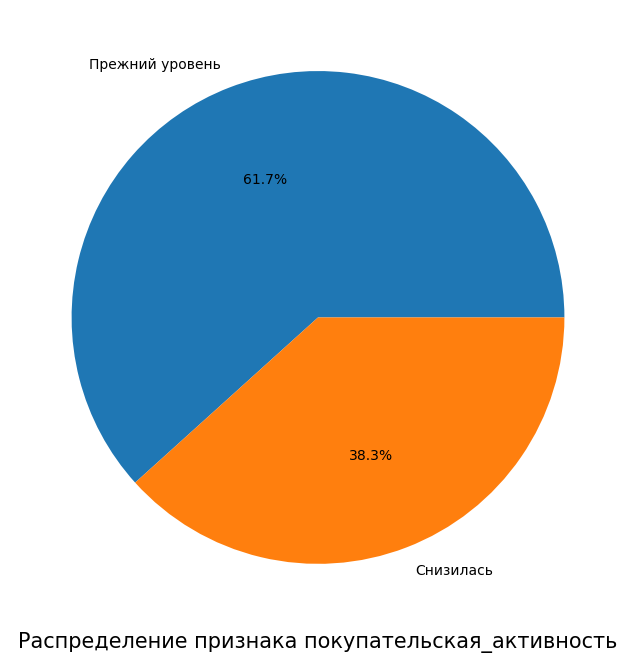

In [87]:
pie_plot('покупательская_активность',
         fontsize=15,
        figsize=(12, 8))

Мы видим, что у более 1/3 клиентов покупательская активность снизилась, что достаточно негативно сказывается на общем состоянии компании.

##### Тип сервиса

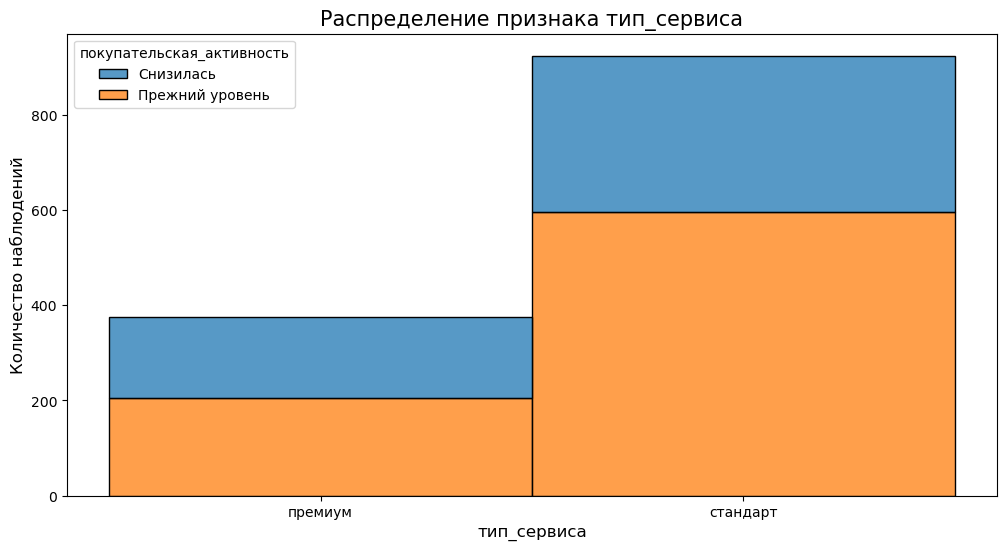

In [32]:
hist_plot('тип_сервиса', hue='покупательская_активность', multiple='stack')

Большая часть пользователей составляют люди со стандратной подпиской (71.1%), что значит, что они являются целевой аудиторией, однако немалая часть из общего числа пользователей пользуется премиум подпиской (28.9%).
Причем распределение целевого признакак таково, что в процентном соотношении класс людей с премиум подпиской теряет имеет больше человек, имеющих снижение покупательской активности, нежели люди без подписки.

##### Разрешить сообщать

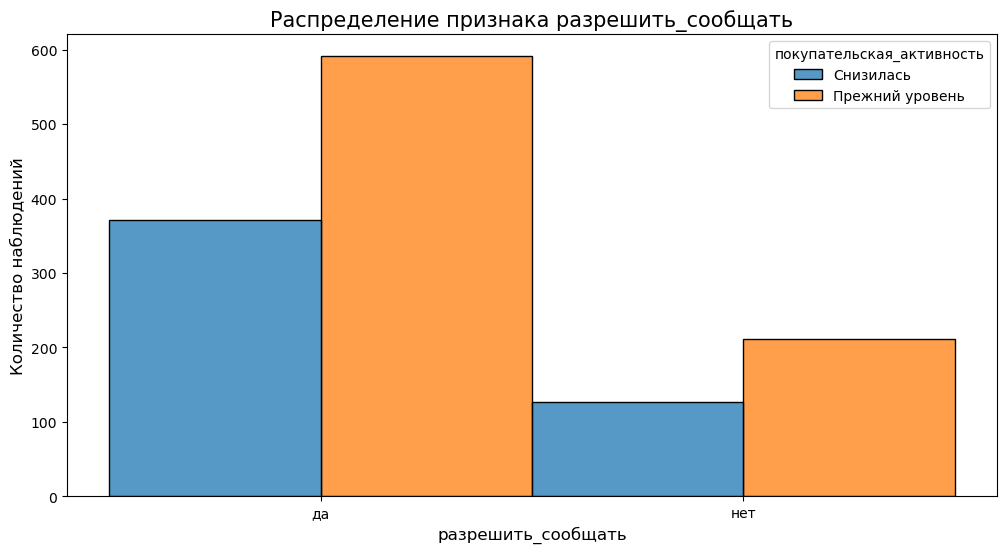

In [33]:
hist_plot('разрешить_сообщать', hue='покупательская_активность', multiple='dodge')

Как мы видим достаточно большое количество пользователей дало согласие на отправку СМС-сообщений (74%), что говорит о лояльности аудитории к сервису и принятию той информации, которую можно распространят среди них.
Причем в процетном соотшении здесь потери по классам примерно одинаковые, что говорит о том, что это признак не сильно влияет на наш целевой признак.
##### Маркет актив 6 месяц

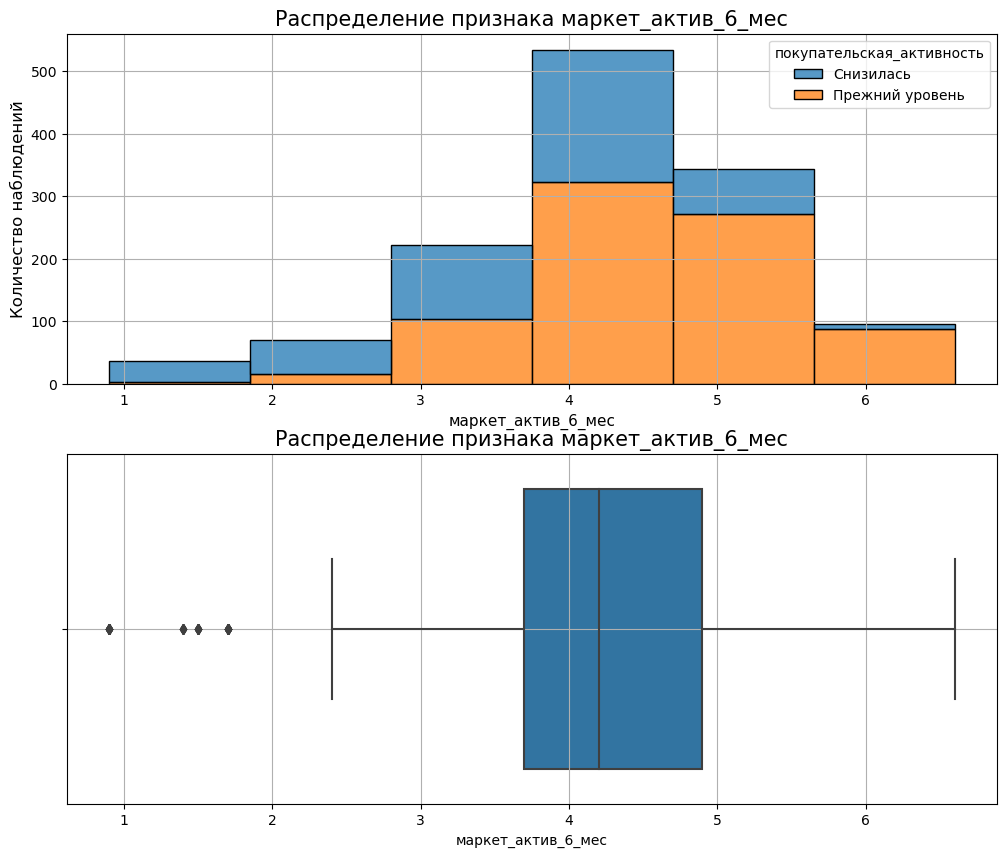

In [34]:
hist_box_plot('маркет_актив_6_мес',
              bins=6,
              fontsize=11,
              figsize=(12, 10),
              hue='покупательская_активность',
              multiple='stack')

Оставим выбросы, так как они характеризуют класс людей со сниженной покупательской способностью

Как мы видим, компания снизила тенденцию к маркетингу через свою пользовтельскую базу 2 месяца назад, после пика, а также мы наблюдаем достаточно низкий показатели по текущему месяцу. Причем основные потери клиентов происходили в период роста этого показателя;

##### Маркет актив тек мес

<Figure size 1500x800 with 0 Axes>

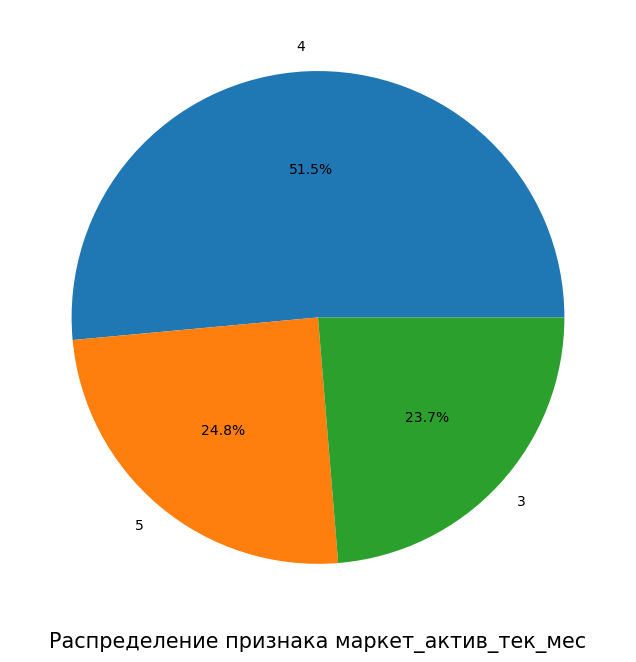

In [35]:
pie_plot('маркет_актив_тек_мес', figsize=(15, 8), fontsize=15);

Мы видим, что в текущем месяце с большей частью выборки (51.5%) с точки зрения маркетинга коммуницировали 4 раза, 5 раз с выборкой из 24.8% пользователей, 3 раза с выборкой из 23.7% процентов, причем эти показатели самые низкие за предыдущие два месяца, что говорит нам о том, что в среднем компания еще больше продвигала тои или иной товар.

##### Длительность

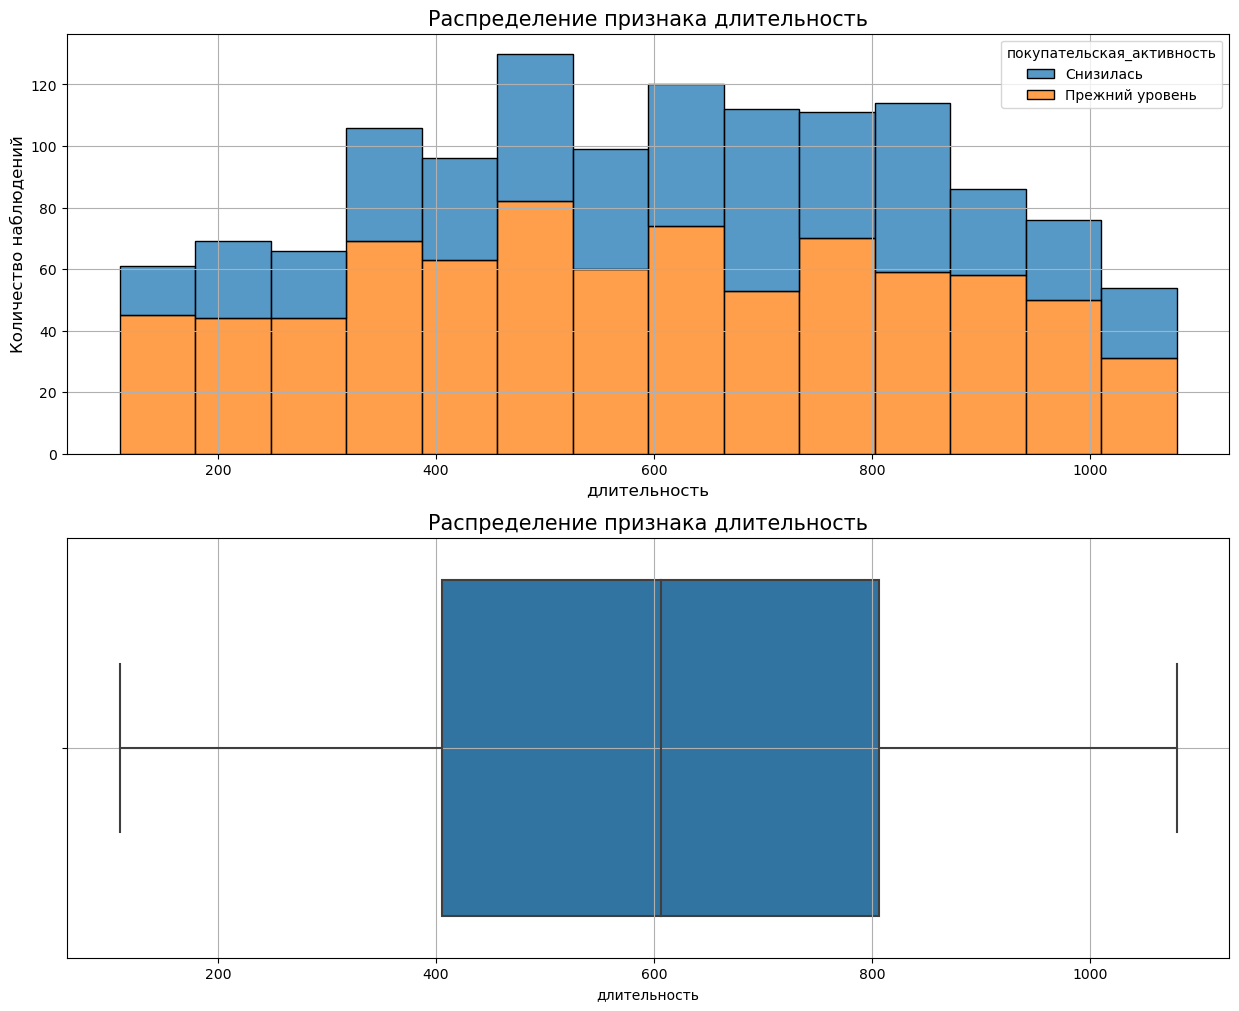

In [36]:
hist_box_plot('длительность',
              df=market_file,
              color='blue',
              hue='покупательская_активность',
              figsize=(15, 12),
              multiple='stack'
             )

Как мы видим, распределение похоже на нормальное, но с достаточно большой дисперсией, что говорит нам о том, что популряность имела положительную динамику, начиная со старта запуска интернет-магазина, потом прирост был стабильный, но около 400 дней назад динамика достаточно ухудшилась.

##### Акционные покупки

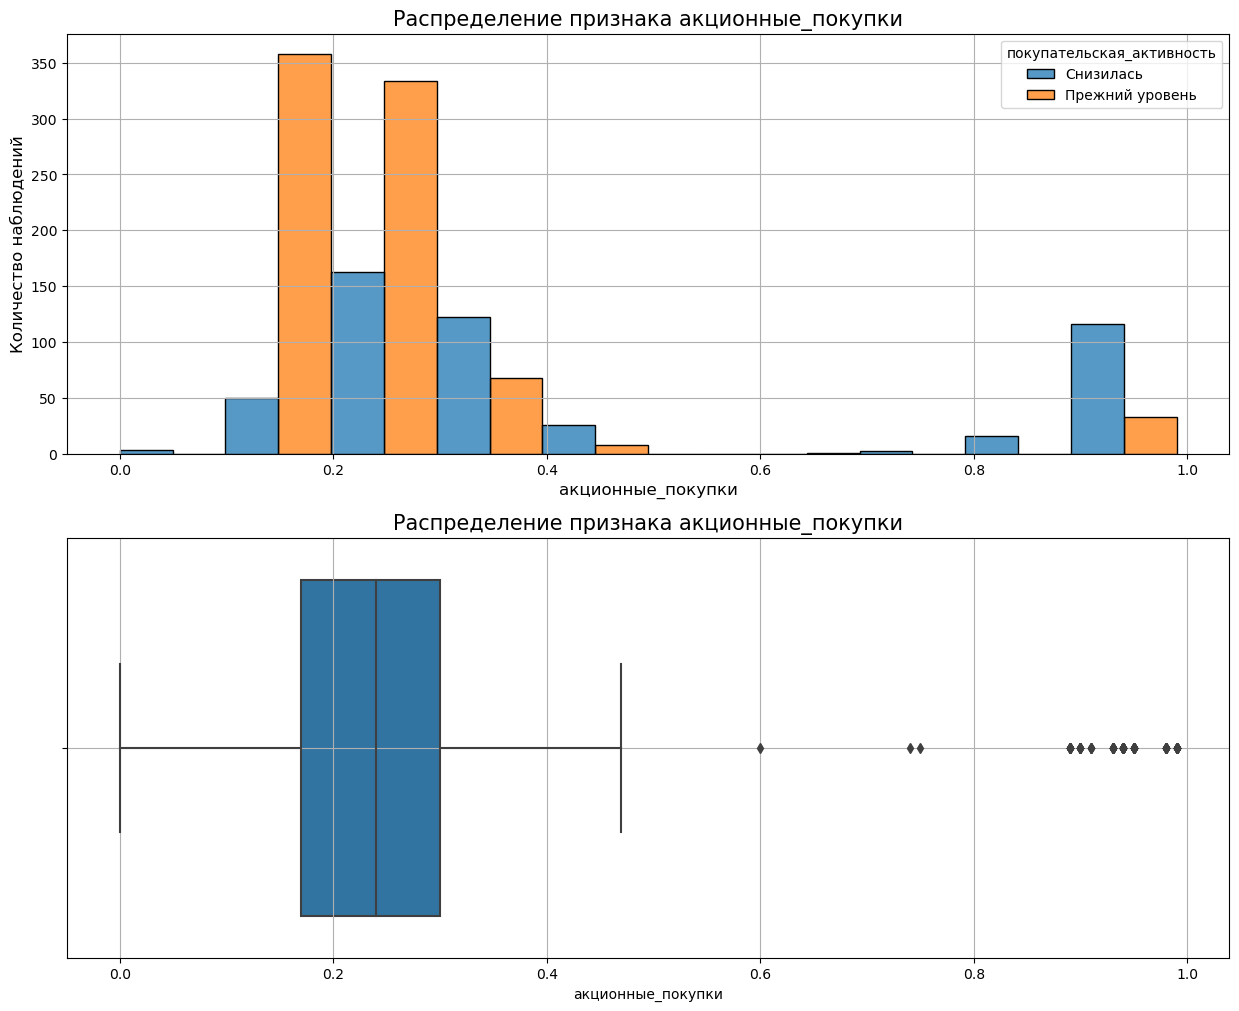

In [37]:
hist_box_plot('акционные_покупки',
          df=market_file,
          bins=10,
          color='orange',
          hue='покупательская_активность',
          multiple='dodge',
          figsize=(15, 12))

Диаграмма box_plot указывает на выбросы после примерно 50% скидки, хотя необходимо учесть скидки и посе этого порога, несмотря на перевес левого класса, поэтому оставим как есть.
За последние 6 месяцев мы видим, что большинство товаров, которые купили пользователи, находятся в диапозоне от 10% до 40%, а также немаленькая часть выборки попадает на акции от 90% до 100%. Эта информация некоторым образом описывает стратегию и введение акции на конкретные товары в интернет-магазине, то есть наиболее привлекательными является категория товаров, которая попадает в вышеупомянутые диапозоны. Также мы видим небольшую часть выборки со скидкой до 10%, что указывает нам на то, что покупатель не очень желает приобретать товары с такой скидкой. Диапозон от 60% до 80% тоже является почти нулевым сегментом, что говорит нам либо о некорректном подборе товаров со стороны продавца, либо о некорректной скидки для покупателей (требуется больше). При этом всем правый класс скидок показывает нам, что в процентном соотношении на огронмых скидках людей, у которых понизилась покупательская активность, значительно больше противоположного класса.

##### Популярная категория

<Figure size 1200x900 with 0 Axes>

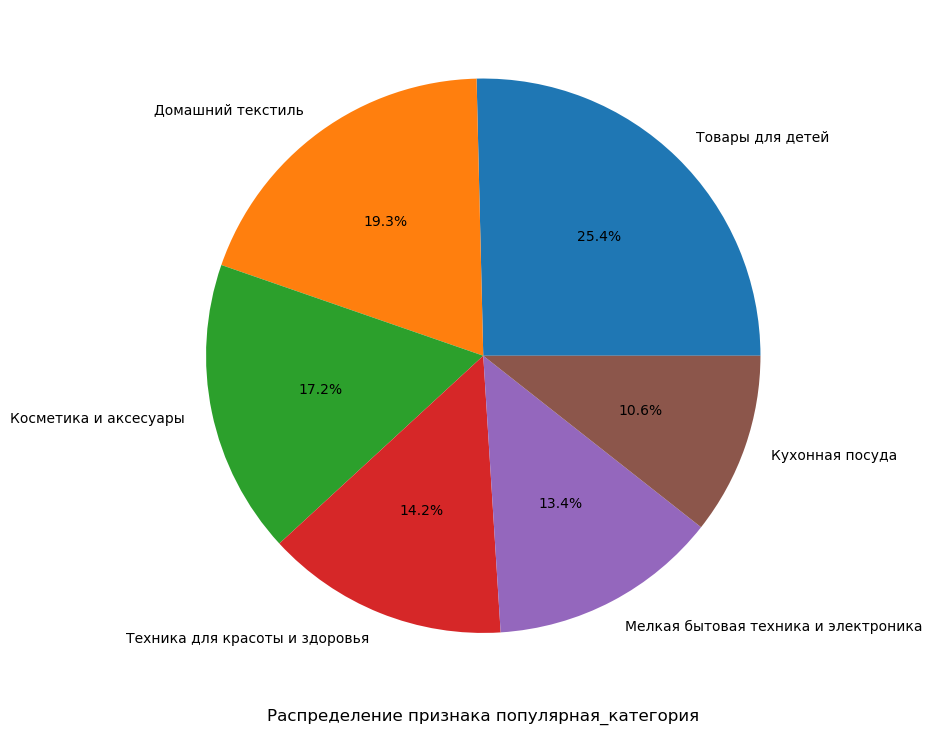

In [38]:
pie_plot('популярная_категория', figsize=(12, 9));

Здесь мы видим следующее:
- Категория `Товары для детей` составляет четверть от всех продаж, что говорит нам о том, что одной из целевой аудиторией являются семьи и их дети.
- `Домашний текстиль` занимает также одну из ведущих частей нашей выборки (19.3%), что частично ссылает нас на категорию `Товары для детей`. Очень вероятно, что они связаны, ведь в семейной жизни (особенно, когда у Вас маленькие дети) необходимо немалое кол-во, например, пастельного белья или разного вида полотенцев.
- Оставшиеся категории товаров, а именно `Косметика и аксуссуары`, `Техника для красоты и здоровья`, `Мелкая бытовая техника и электроника`, `Кухонная посуда` также имеют немаленький вклад в общее кол-во продаж, однако тут уже сложно выявлять какие-либо зависимости, необходимы иные исследования.


##### Средний просмотр категорий за визит

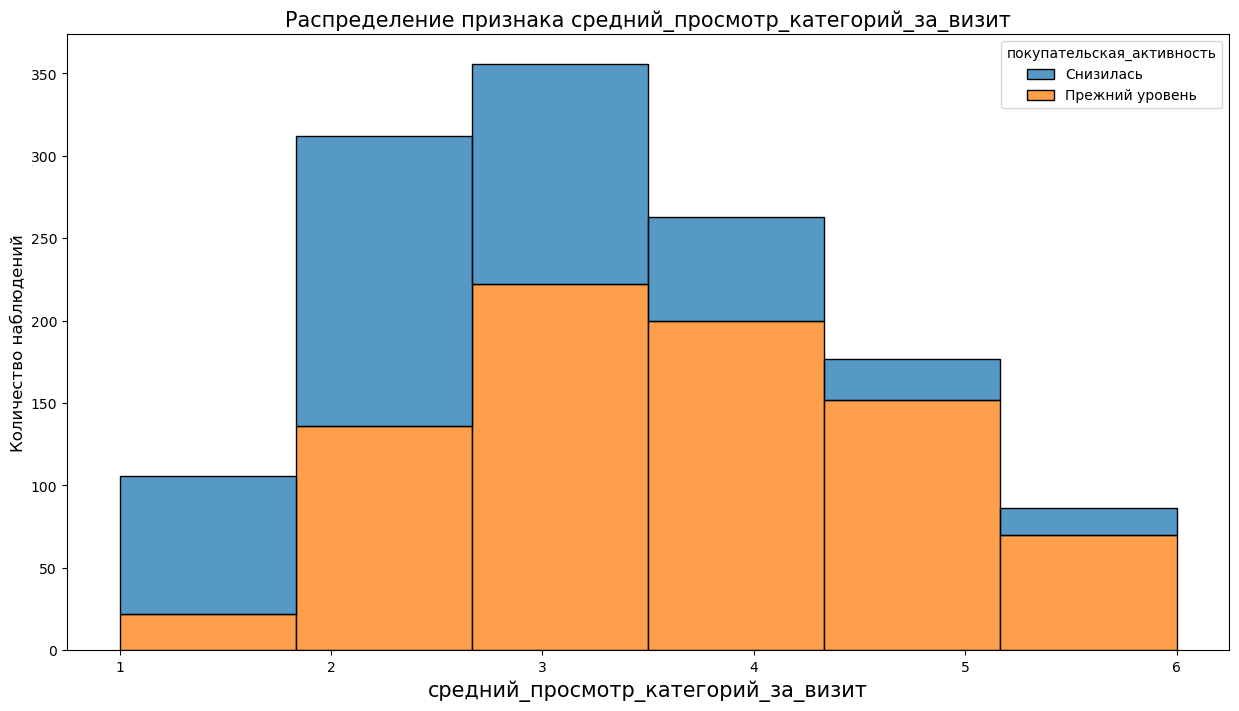

<Figure size 2000x800 with 0 Axes>

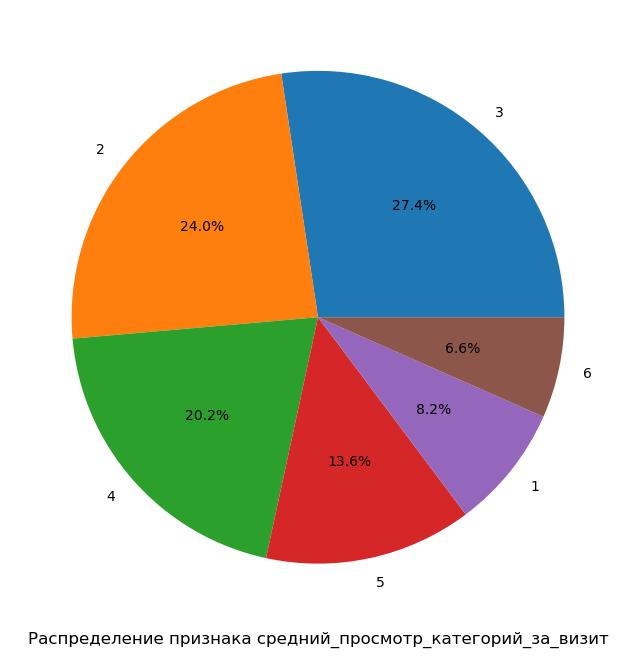

In [39]:
hist_plot('средний_просмотр_категорий_за_визит',
              df=market_file,
              figsize=(15, 8),
              fontsize=15,
              hue='покупательская_активность',
              multiple='stack',
              bins=6)
pie_plot('средний_просмотр_категорий_за_визит', figsize=(20, 8))

Как мы видим, большая часть выборки (68%) являются просмотрами от 3 до 6 категорий за визит, что говорит нам о наполненности сайта товарами и заинтересованности пользователей. Просмотр 1 и 2 категорий за визит напротив заставляет задуматься о ассортименте, ведь 32% посещений, в течение которых было просмотрено так мало категорий, говорит нам либо о недостаточной наполненности магазина и(или) неграмотной политики ценообразования (были приведены наиболее вероятностные причины).
Также мы можем наблюдать тенденцию того, что при малом кол-во просмотров увеличивается и процент и общее кол-во людей со сниженной покупательской способностью.

##### Неоплаченные продукты штук квартал

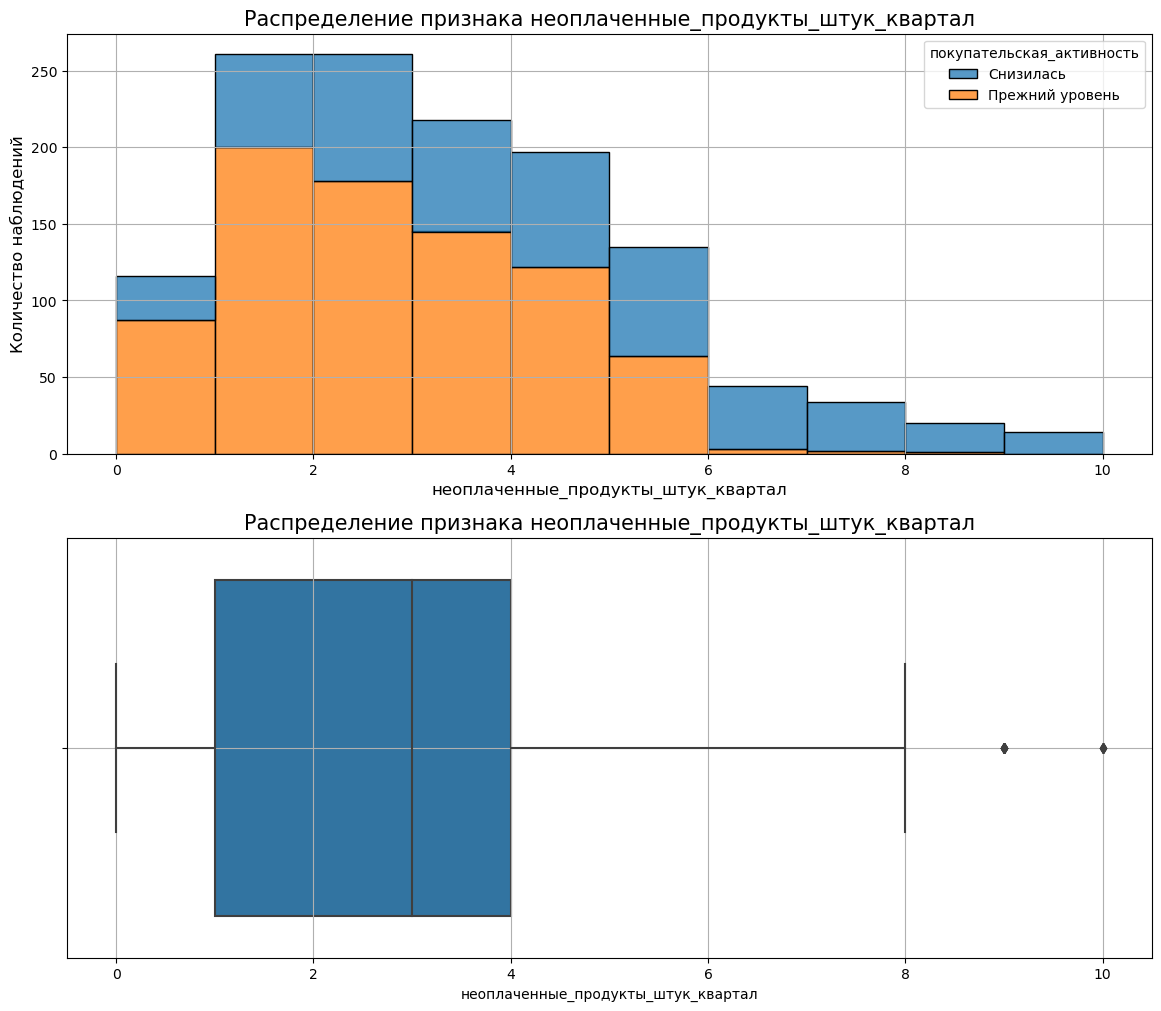

In [40]:
hist_box_plot('неоплаченные_продукты_штук_квартал',
              bins=10,
              figsize=(14, 12),
              hue='покупательская_активность',
              multiple='stack')

Оставим выбросы, так как в этих моментах подавляющее большинство составляют люди со сниженной покупательской активностью.

Мы видим, что большая часть клиентов содержит в своей коризне от 1 до 6 неоплаченных товаров, по разбиению по покупательской активности мы видим, что с увеличением кол-ва неполаченных товаров в корзине процент людей со сниженной покупательской активностью увеличивается вплоть то 100 процентов, что говорит нам о том, что этот признак не очень хорошо влияет на таргет.

##### Ошибка сервиса

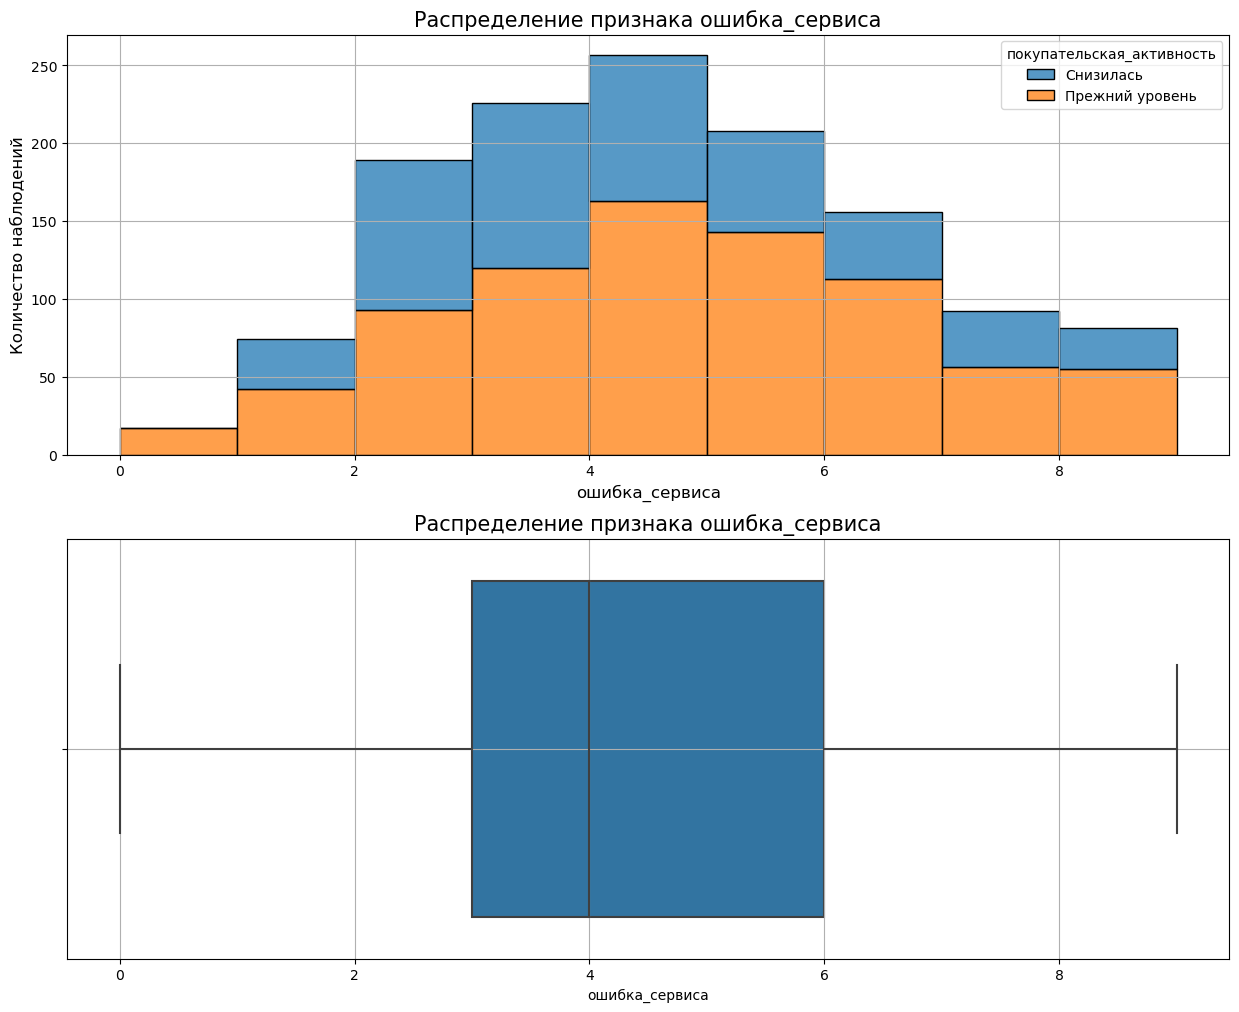

In [41]:
hist_box_plot('ошибка_сервиса',
          bins=max(market_file.ошибка_сервиса) - min(market_file.ошибка_сервиса),
          color='pink',
          hue='покупательская_активность',
          multiple='stack',
          figsize=(15, 12))

Распределение этого признака походит на нормальное, немного смещено влево. В целом достаточно неоднозначный признак. Можно сказать только то, что необходимо сместить мат ожидание как можно ближе к нулю :)


##### Страниц за визит

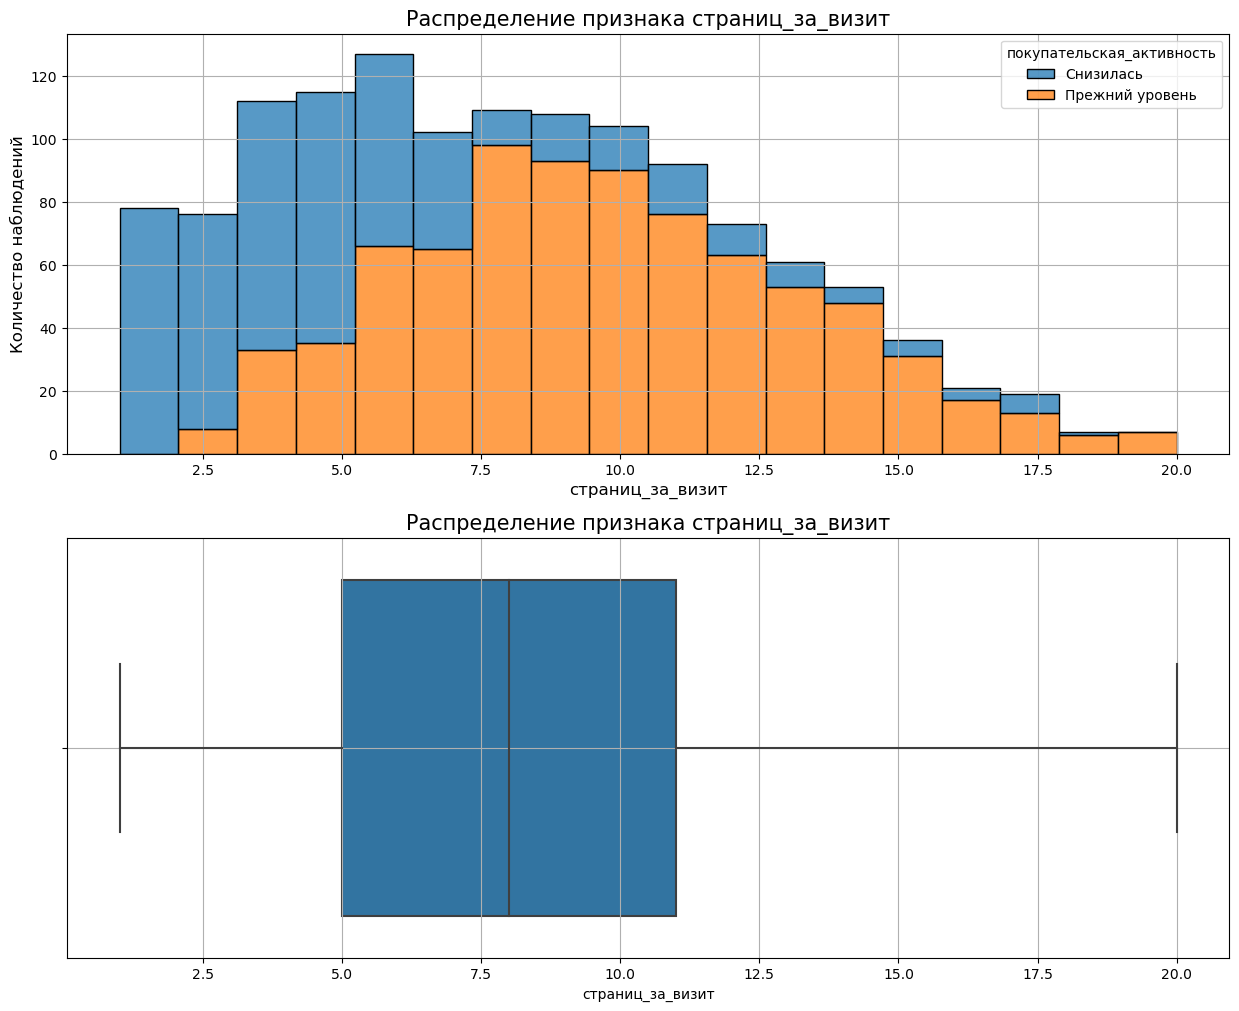

In [42]:
hist_box_plot('страниц_за_визит',
             df=market_file,
             hue='покупательская_активность',
             figsize=(15, 12),
             multiple='stack')

Интересное наблюдение, а именно мы видим, что 5 страниц за визить подавляющим большинством является клиент с пониженной покупательской активностью, что говорит нам о том, что это один из важнейших признаков, который необходимо рассматривать дальше, причем в boxplot мы видим, что около четверти всех наблюдений находится именно в том месте, где происходит спад активности людей.

#### market_money

In [43]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


##### Период

<Figure size 800x1500 with 0 Axes>

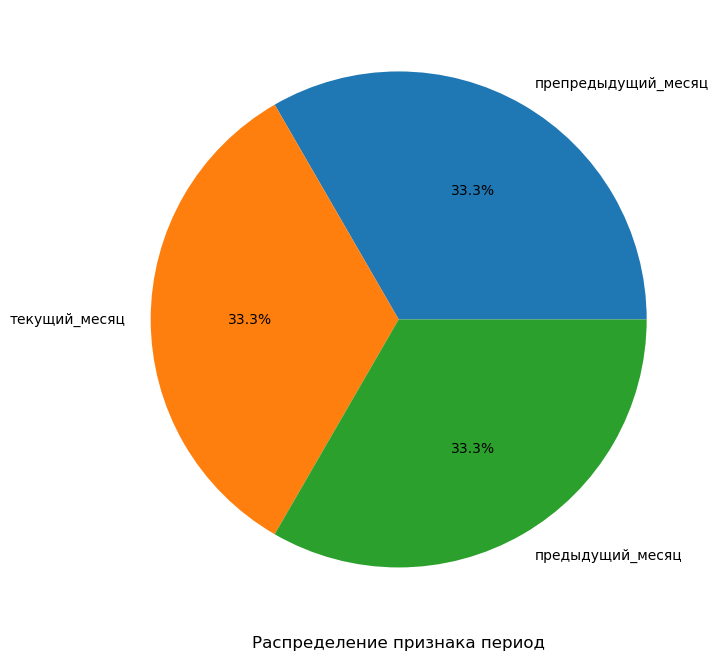

In [44]:
pie_plot('период', df=market_money, figsize=(8, 15))

Из этого признака и его распределения мы ничего интересного не можем вынести, так как доли абсолютно одинаковые, однако используем его для анализа выручки в этом же датафрейме.


##### Выручка

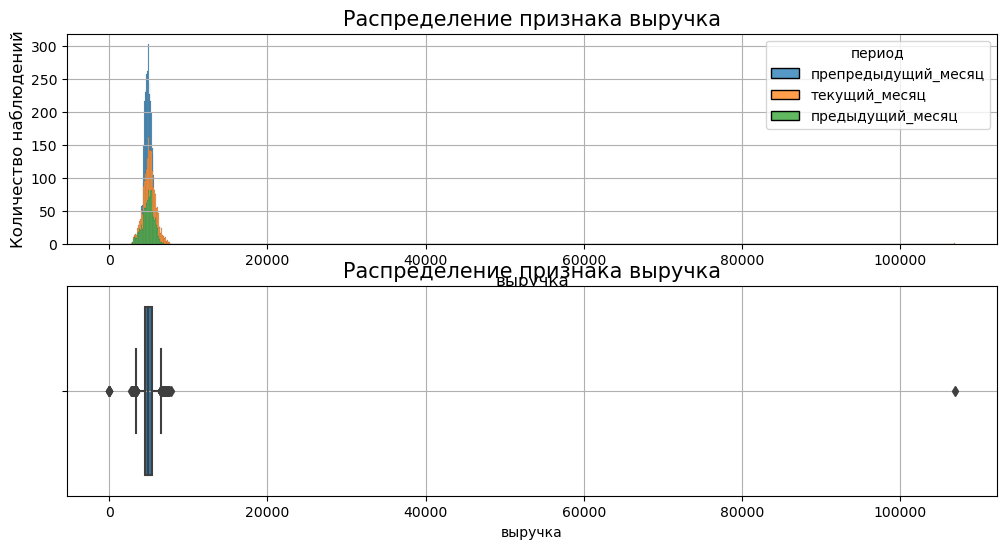

In [45]:
hist_box_plot('выручка', df=market_money, hue='период', multiple="stack")

В признаке есть выбросы, изучим их и по возможности ликвидируем

In [46]:
market_money.выручка.describe().to_frame()

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


In [47]:
len(market_money.выручка) - len(market_money.query('выручка < 106862 and выручка > 0')['выручка'])

7

Выбросов очень мало, поэтому удалим их

In [48]:
market_money = market_money.query('выручка < 106862 and выручка > 0')
market_money['выручка'].describe().to_frame()

,выручка
count,3893.000000
mean,5007.282918
std,679.724898
min,2758.700000
25%,4592.000000
50%,4959.000000
75%,5363.000000
max,7799.400000


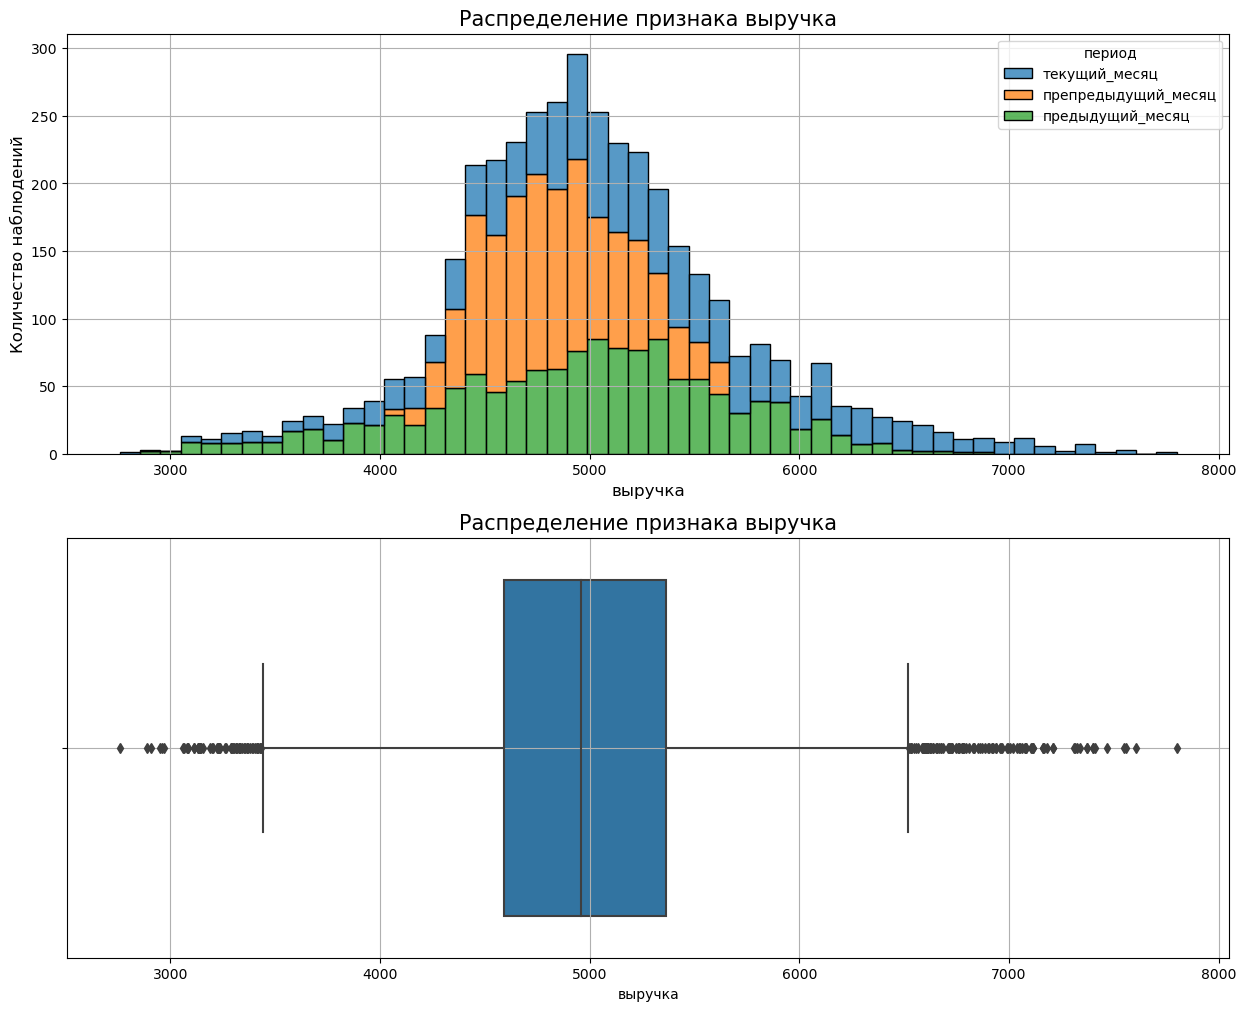

In [88]:
hist_box_plot('выручка', df=market_money, hue='период', multiple="stack", figsize=(15, 12))

На box_plot мы видим выбросы, но они связаны с тем, что в текущем месяце больше дисперсия, чем в остальных, поэтому оставим эти выбросы для более удачного обучения модели.

Итак, мы имеем 3 периода, а именно текущий месяц, предыдущий и препредыдущий. Ссылаясь на распределение сделаем некоторые выводы:
- Во всех распределениях наблюдается одинаковое кол-во наблюдений, однако сами распределния значительно различаются;
- С течением времени мат ожидание находится на приблизительно одинаковом уровне, однако дисперсия увеличивается;
- В случае с предыдущим месяцем относительно mu += σ большая часть выборки наблюдается с левой стороны, а в текущем периоде наоборот - с правой, что положительно влияет на общее число выручки;
- Можно предположить, что либо старая аудитория больше стала доверять сервису и покупать все больше товаров, либо наплыв новых пользователей с немного иными ежемесячными тратами повлиял на статистику, но, судя по анализу датафрейма market_file, предпочтительней предположить первый вариант.

#### market_time

In [50]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


##### Период

<Figure size 1200x600 with 0 Axes>

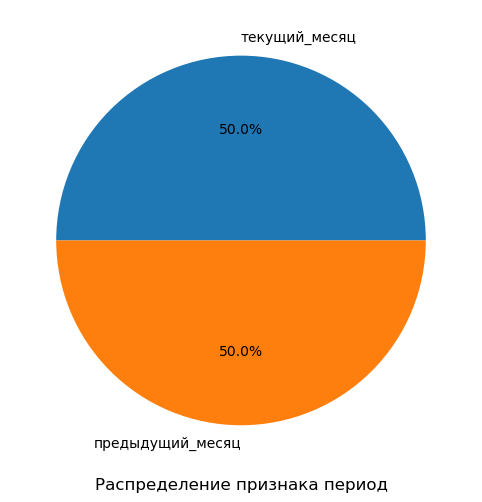

In [51]:
pie_plot('период', df=market_time)

Опять же, ничего интересного, используем факт того, что наблюдений снова равное кол-во в анализе времени, проведенного на сайте.

##### Минут (длительность посещения)

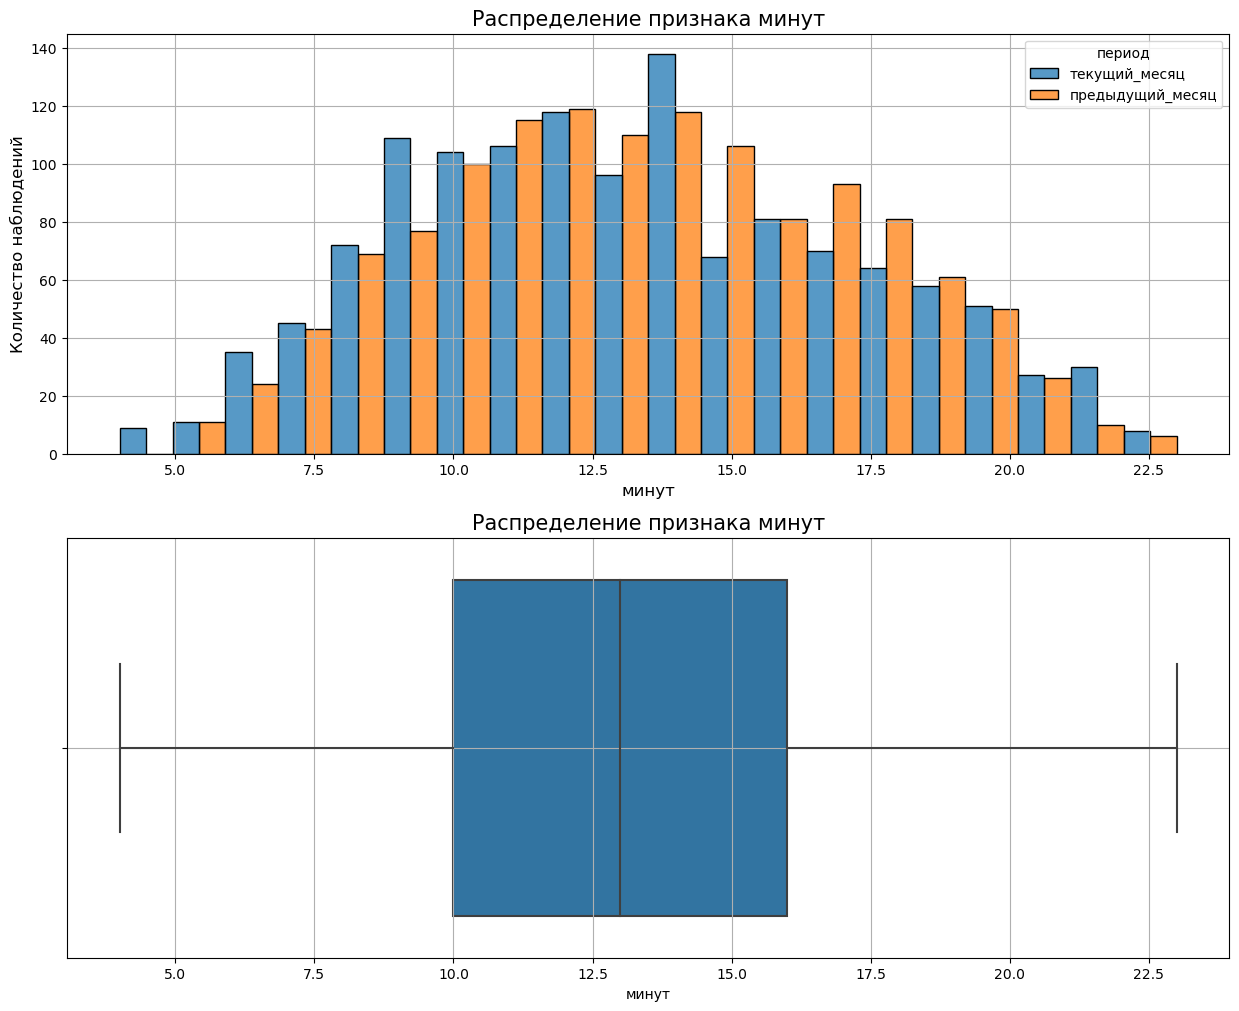

In [52]:
hist_box_plot('минут', figsize=(15, 12),
              df=market_time, bins=20,
              hue='период', multiple='dodge')

Как мы видим, распределение снова нормальное, каких-то существенный различий в посещениях сайта между периодами нет, среднее посещение сайта - 10 - 15 минут.

#### money

In [53]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


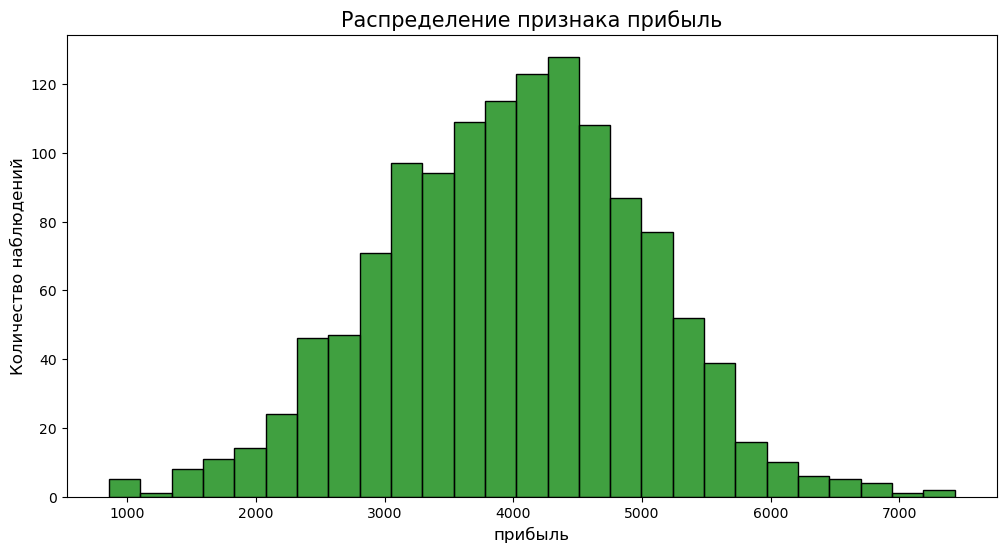

In [54]:
hist_plot('прибыль', df=money)

Прибыль также имеет нормальное распределение, ссылаясь на анализ по выручке, можно сказать, что магазин имеет достаточно неплохую наценку на услуги, среденее значение находится в диапозоне 3500 - 5500 рублей.

#### Отбор клиентов по признаку покупательской активности не менее трёх месяцев
Для отбора покупательской активности нам необходимо сослаться на dataframe **market_money**, его необходимо соединить с основной таблицей по id покупателя, будем иметь это в виду на следующем этапе проекта.

#### Вывод:
Был проведен исследовательский анализ по каждому из dataframe, сделаны следующие выводы:

1) **market_file**:
- **Покупательская активность** - Мы видим, что у более 1/3 клиентов покупательская активность снизилась, что достаточно негативно сказывается на общем состоянии компании.
- **Тип сервиса** - Большая часть пользователей составляют люди со стандратной подпиской (71.1%), что значит, что они являются целевой аудиторией, однако немалая часть из общего числа пользователей пользуется премиум подпиской (28.9%). Причем распределение целевого признакак таково, что в процентном соотношении класс людей с премиум подпиской теряет имеет больше человек, имеющих снижение покупательской активности, нежели люди без подписки.
- **Разрешить сообщать** - Как мы видим достаточно большое количество пользователей дало согласие на отправку СМС-сообщений (74%), что говорит о лояльности аудитории к сервису и принятию той информации, которую можно распространят среди них. Причем в процетном соотшении здесь потери по классам примерно одинаковые, что говорит о том, что это признак не сильно влияет на наш целевой признак.
- **Маркет актив 6 месяц** - Как мы видим, компания снизила тенденцию к маркетингу через свою пользовтельскую базу 2 месяца назад, после пика, а также мы наблюдаем достаточно низкий показатели по текущему месяцу. Причем основные потери клиентов происходили в период роста этого показателя;
- **Маркет актив тек мес** - Мы видим, что в текущем месяце с большей частью выборки (51.5%) с точки зрения маркетинга коммуницировали 4 раза, 5 раз с выборкой из 24.8% пользователей, 3 раза с выборкой из 23.7% процентов, причем эти показатели самые низкие за предыдущие два месяца, что говорит нам о том, что в среднем компания еще больше продвигала тои или иной товар.
- **Длительность** - Как мы видим, распределение похоже на нормальное, но с достаточно большой дисперсией, что говорит нам о том, что популряность имела положительную динамику, начиная со старта запуска интернет-магазина, потом прирост был стабильный, но около 400 дней назад динамика достаточно ухудшилась.
- **Акционные покупки** - Диаграмма box_plot указывает на выбросы после примерно 50% скидки, хотя необходимо учесть скидки и посе этого порога, несмотря на перевес левого класса, поэтому оставим как есть.За последние 6 месяцев мы видим, что большинство товаров, которые купили пользователи, находятся в диапозоне от 10% до 40%, а также немаленькая часть выборки попадает на акции от 90% до 100%. Эта информация некоторым образом описывает стратегию и введение акции на конкретные товары в интернет-магазине, то есть наиболее привлекательными является категория товаров, которая попадает в вышеупомянутые диапозоны. Также мы видим небольшую часть выборки со скидкой до 10%, что указывает нам на то, что покупатель не очень желает приобретать товары с такой скидкой. Диапозон от 60% до 80% тоже является почти нулевым сегментом, что говорит нам либо о некорректном подборе товаров со стороны продавца, либо о некорректной скидки для покупателей (требуется больше). При этом всем правый класс скидок показывает нам, что в процентном соотношении на огронмых скидках людей, у которых понизилась покупательская активность, значительно больше противоположного класса.
- **Популярная категория** - Здесь мы видим следующее:
    - Категория `Товары для детей` составляет четверть от всех продаж, что говорит нам о том, что одной из целевой аудиторией являются семьи и их дети.
    - `Домашний текстиль` занимает также одну из ведущих частей нашей выборки (19.3%), что частично ссылает нас на категорию `Товары для детей`. Очень вероятно, что они связаны, ведь в семейной жизни (особенно, когда у Вас маленькие дети) необходимо немалое кол-во, например, пастельного белья или разного вида полотенцев.
    - Оставшиеся категории товаров, а именно `Косметика и аксуссуары`, `Техника для красоты и здоровья`, `Мелкая бытовая техника и электроника`, `Кухонная посуда` также имеют немаленький вклад в общее кол-во продаж, однако тут уже сложно выявлять какие-либо зависимости, необходимы иные исследования.
- **Средний просмотр категорий за визит** - Как мы видим, большая часть выборки (68%) являются просмотрами от 3 до 6 категорий за визит, что говорит нам о наполненности сайта товарами и заинтересованности пользователей. Просмотр 1 и 2 категорий за визит напротив заставляет задуматься о ассортименте, ведь 32% посещений, в течение которых было просмотрено так мало категорий, говорит нам либо о недостаточной наполненности магазина и(или) неграмотной политики ценообразования (были приведены наиболее вероятностные причины).Также мы можем наблюдать тенденцию того, что при малом кол-во просмотров увеличивается и процент и общее кол-во людей со сниженной покупательской способностью.
- **Неоплаченные продукты штук квартал** - Мы видим, что большая часть клиентов содержит в своей коризне от 1 до 6 неоплаченных товаров, по разбиению по покупательской активности мы видим, что с увеличением кол-ва неполаченных товаров в корзине процент людей со сниженной покупательской активностью увеличивается вплоть то 100 процентов, что говорит нам о том, что этот признак не очень хорошо влияет на таргет.
- **Ошибка сервиса** - Распределение этого признака походит на нормальное, немного смещено влево. В целом достаточно неоднозначный признак. Можно сказать только то, что необходимо сместить мат ожидание как можно ближе к нулю :)
- **Страниц за визит** - Интересное наблюдение, а именно мы видим, что 5 страниц за визить подавляющим большинством является клиент с пониженной покупательской активностью, что говорит нам о том, что это один из важнейших признаков, который необходимо рассматривать дальше, причем в boxplot мы видим, что около четверти всех наблюдений находится именно в том месте, где происходит спад активности людей.

2) **market_money**:
- **Выручка (период)** - На box_plot мы видим выбросы, но они связаны с тем, что в текущем месяце больше дисперсия, чем в остальных, поэтому оставим эти выбросы для более удачного обучения модели. Итак, мы имеем 3 периода, а именно текущий месяц, предыдущий и препредыдущий. Ссылаясь на распределение сделаем некоторые выводы:
    - Во всех распределениях наблюдается одинаковое кол-во наблюдений, однако сами распределния значительно различаются;
    - С течением времени мат ожидание находится на приблизительно одинаковом уровне, однако дисперсия увеличивается;
    - В случае с предыдущим месяцем относительно mu += σ большая часть выборки наблюдается с левой стороны, а в текущем периоде наоборот - с правой, что положительно влияет на общее число выручки;
    - Можно предположить, что либо старая аудитория больше стала доверять сервису и покупать все больше товаров, либо наплыв новых пользователей с немного иными ежемесячными тратами повлиял на статистику, но, судя по анализу датафрейма market_file, предпочтительней предположить первый вариант.

3) **market_time**:
- **Минут/Длительность посещений (период)** - Как мы видим, распределение снова нормальное, каких-то существенный различий в посещениях сайта между периодами нет, среднее посещение сайта - 10 - 15 минут.


4) **money**:
- Прибыль также имеет нормальное распределение, ссылаясь на анализ по выручке, можно сказать, что магазин имеет достаточно неплохую наценку на услуги, среденее значение находится в диапозоне 3500 - 5500 рублей.



#### Рекомендации:
- Необходимо пересмотреть акционную политику, ввести более интересные ивенты, при этом не снижать кол-ва акций, ведь люди уже привыкли к ним.
- Ссылаясь на то, что аудитория дает согласие на рассылку сообщений, сделать какие-то вознаграждения в виде бонусов на площадке и усилить маркетинговую стратегию, используя этот и иные способы продвижения.
- Необходимо сделать больший упор на основные категории товаров, а именно на `Товары для детей`, `Домашний текстиль`, расширить ассортимент, ввести большое кол-во акций для продвижения этих категорий. Также стоит обратить внимание на оставшиеся категории.
- Нужно переработать интерфейс сайта или доработать рекомендательные системы для покупателей, таким образом получится увеличить пребывание клиентов на сайте.
- Ввести поощрения для покупателей такиим образом, чтобы товары в корзине не задерживались надолго, например, ввести поощрение в виде дополнительных бонусов, если покупатель оплатит товар в течение некоторого времени после его добавления в корзину.
- Также стоит учесть признак **Ошибка сервиса** и наладить сайт так, чтобы этот признак минимизировать.


## Объединение таблиц

Сделаем объединение таблиц. Для начала объединим таблицы **market_file** и **market_money** для фильтрации пользоватлей по признаку активности за последние 3 месяца, а дальше объединим **market_time**:

In [55]:
market_money.head()

,id,период,выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0


In [56]:
market_pivot = (market_money
                .pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
                .reset_index()
               )
market_pivot       

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,NaN,NaN,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
...,...,...,...,...
1295,216643,3664.0,4704.0,4741.7
1296,216644,4729.0,5299.0,5353.0
1297,216645,5160.0,5334.0,5139.2
1298,216646,4923.0,4725.0,5224.6


market_time

In [57]:
market_time

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдущий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


In [58]:
pivot_time = (market_time
              .pivot_table(index='id', columns='период', values='минут', aggfunc='sum')
              .reset_index()
              )
pivot_time

период,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


Теперь соединим таблицы с **market_file**:

In [59]:
df = pd.merge(market_file, market_pivot, on='id', how='right')
df = pd.merge(df, pivot_time, on='id', how='right')
df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


Переименуем столбцы с периодами в соответсвии с их изначальными таблицами:

In [60]:
df = df.rename(columns={'предыдущий_месяц_x': 'предыдущий_месяц_выручка',
                        'препредыдущий_месяц': 'препредыдущий_месяц_выручка',
                        'текущий_месяц_x': 'текущий_месяц_выручка',
                        'предыдущий_месяц_y': 'предыдущий_месяц_минут',
                        'текущий_месяц_y': 'текущий_месяц_минут'})
df = df.set_index('id')
df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [61]:
df.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               3
препредыдущий_месяц_выручка            3
текущий_месяц_выручка                  1
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

Удалим пропуски:

In [62]:
df = df.dropna()
df.shape

(1296, 17)

## Корреляционный анализ

                                Feature         VIF
0                                 const  352.524089
1                    маркет_актив_6_мес    1.220849
2                  маркет_актив_тек_мес    1.044578
3                          длительность    1.099452
4                     акционные_покупки    1.185679
5   средний_просмотр_категорий_за_визит    1.178602
6    неоплаченные_продукты_штук_квартал    1.198629
7                        ошибка_сервиса    1.079350
8                      страниц_за_визит    1.418264
9              предыдущий_месяц_выручка    4.263015
10          препредыдущий_месяц_выручка    1.612075
11                текущий_месяц_выручка    3.896191
12               предыдущий_месяц_минут    1.526838
13                  текущий_месяц_минут    1.321172





interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 

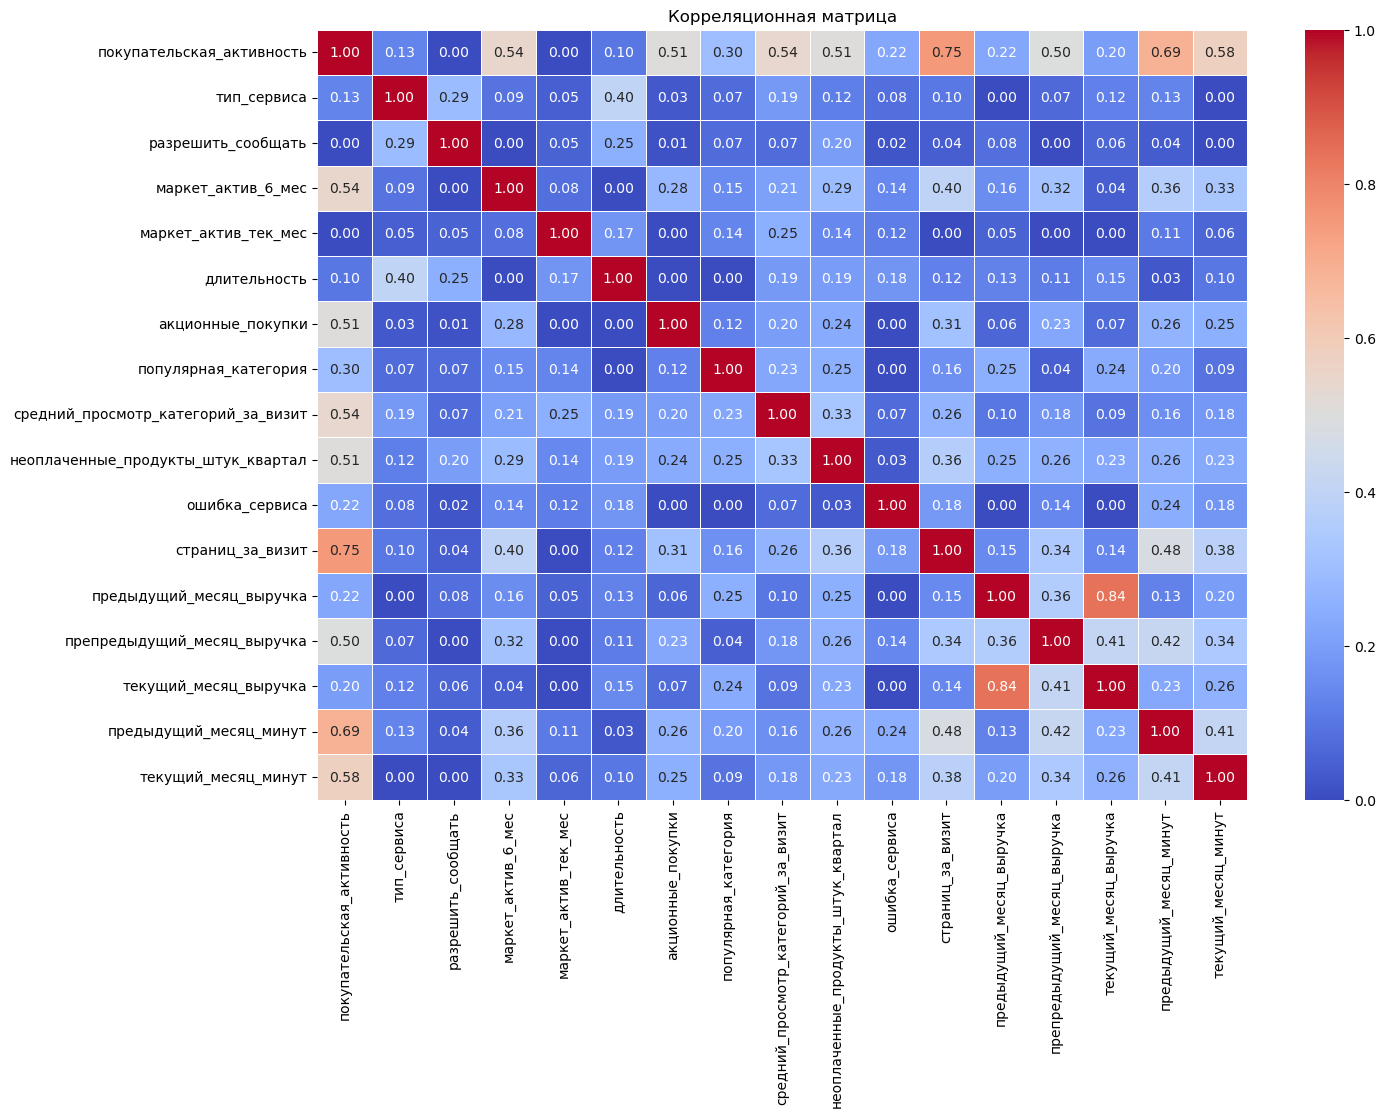

In [63]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = df[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
        'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
        'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',
        'предыдущий_месяц_минут', 'текущий_месяц_минут']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
print('\n\n\n\n')
plt.figure(figsize=(15, 10))
sns.heatmap(df.phik_matrix(), annot=True, fmt='.2f', linewidth=.5, cmap='coolwarm');
plt.title('Корреляционная матрица');

Как мы видим из анализа VIF и корреляционного анализа, то у большинства признаков практически отсутствует какая-либо мультиколлинераность, но выделяются признаки **предыдущий_месяц_выручка** и **текущий_месяц_выручка**, причем на корреляционной матрице их коэффицент больше всего, однако их значения также меньше 5, что указывает на умеренную мультиколлинеарность, так что не стоит особо беспокоиться.

![image.png](Chaddok.png)

Из корреляционной матрицы выделяется большое кол-во признаков на предмет линейной зависимости, рассмотрим самые интересные, а именно:

- **покупательская_активность** - **страниц_за_визит**
- **покупательская_активность** - **предыдущий_месяц_минут**
- **покупательская_активность** - **текущий_месяц_минут**
- **предыдущий_месяц_выручка** - **текущий_месяц_выручка**

Проанализируем последние признаки с разбиением на **страниц_за_визит**, **предыдущий_месяц_минут**, **текущий_месяц_минут***

In [64]:
def scatter_plot(feature, value, df=df, figsize=(10, 10)):
    try:
        if feature not in df.columns or value not in df.columns:
            raise ValueError(f"Один из столбцов: '{feature}' или '{value}' не найден в DataFrame")
         
        hue = ['страниц_за_визит', 'предыдущий_месяц_минут', 'текущий_месяц_минут', 'покупательская_активность']
        fig, ax = plt.subplots(1, 4, figsize=figsize)
        fig.suptitle(f'Зависимость значения {value} от {feature}')
        for i, item in enumerate (hue):
            sns.scatterplot(data=df,
                           x=feature,
                           y=value, 
                           hue=hue[i],
                           ax=ax[i])
            ax[i].set_xlabel(f'Значения {feature}')
            ax[i].set_ylabel(f'Значения {value}')
            ax[i].grid()
    except Exception as e:
        print(f'Что-то пошло не так...\n{e}\nИзучите функцию scatter_plot')

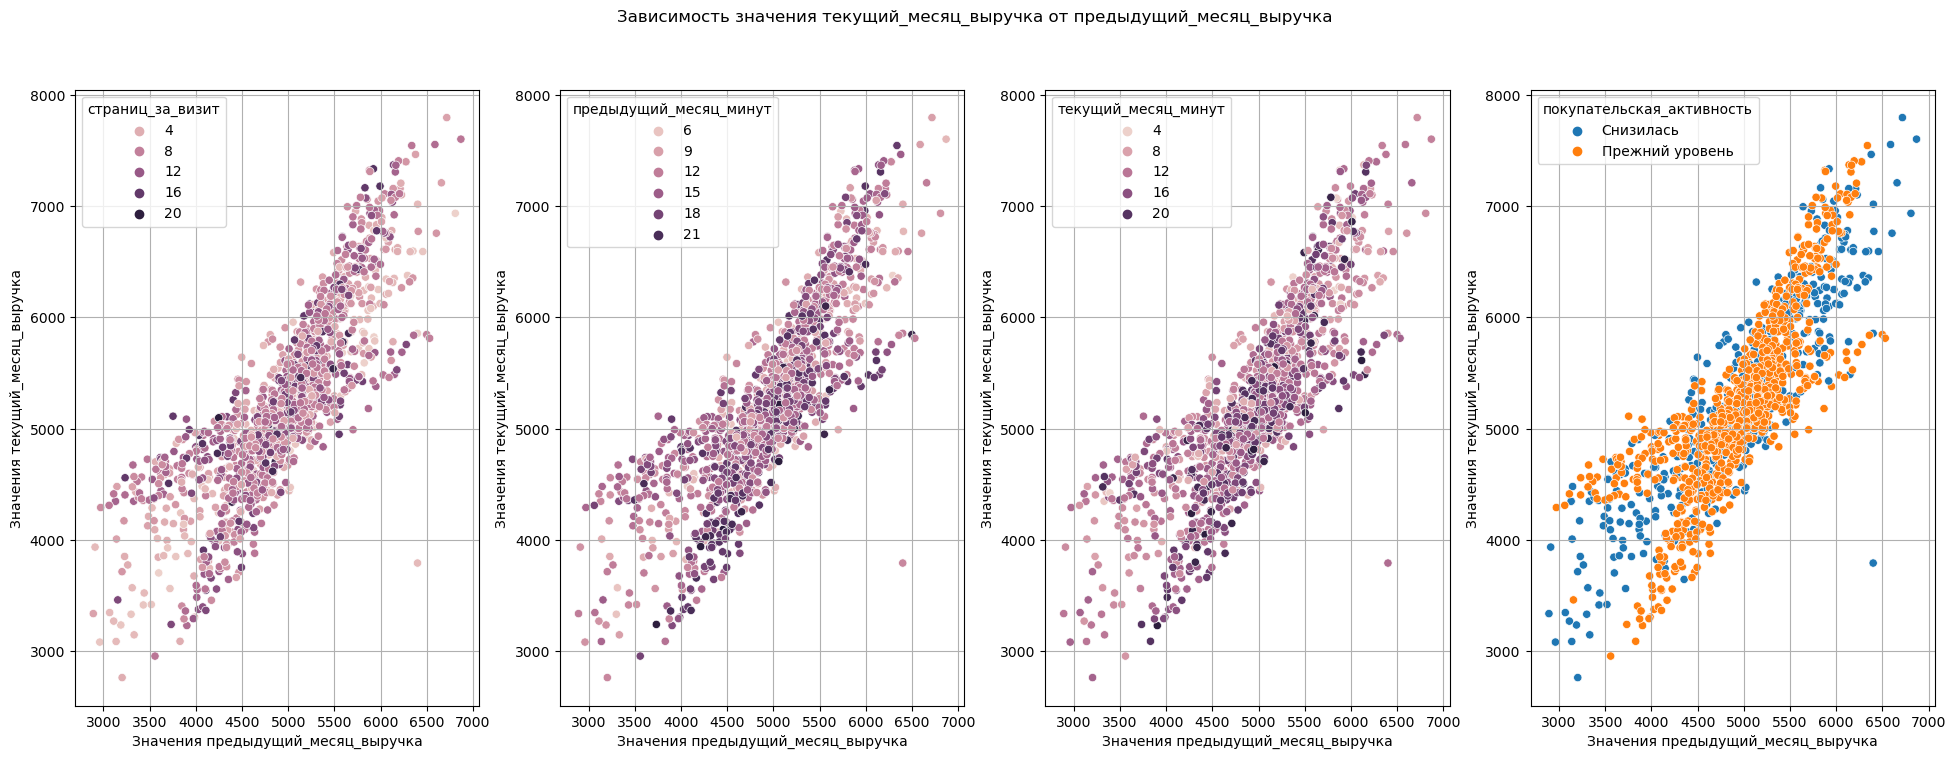

In [65]:
scatter_plot('предыдущий_месяц_выручка', 'текущий_месяц_выручка', figsize=(24, 8))

### Вывод

Как показал коэффицент корреляции, между признаками **предыдущий_месяц_выручка** и **текущий_месяц_выручка** наблюдается линейная зависимость.

- **Первый график (страниц_за_визит):** Несмотря на различия в количестве страниц за визит, основная зависимость между предыдущей и текущей выручками остается линейной.
  
- **Второй график (предыдущий_месяц_минут):** Длительность времени, проведенного на сайте в предыдущем месяце, также показывает, что чем больше было времени, тем выше выручка как в предыдущем, так и в текущем месяце, что тоже подкрепляет линейную зависимость.

- **Третий график (текущий_месяц_минут):** Здесь наблюдается аналогичная картина: большее количество минут, проведенных на сайте в текущем месяце, связано с более высокой текущей выручкой, но основная линейность зависимостей сохраняется.

- **Четвертый график (покупательская_активность):** Вне зависимости от изменения покупательской активности (снизилась или осталась на прежнем уровне) основная зависимость между значениями выручек также остается на уровне линейности.

Таким образом, предыдущая выручка служит сильным предиктором для определения текущей выручки независимо от исследуемых параметров. Можно предположить, что выручка в предыдущем месяце является основным драйвером текущей выручки.



##  Использование пайплайнов
Наш целевой признак - **Покупательская активность**, поэтому проверим его на дисбаланс, предварительно кодировав категории следующим образом:
- Снизилась - 1
- Прежний уровень - 0

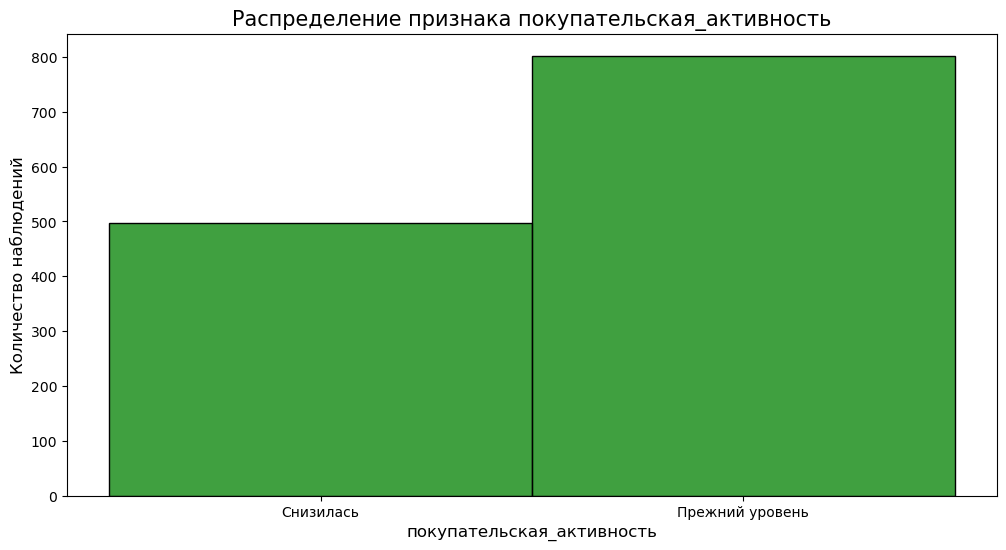

In [66]:
df['покупательская_активность_num'] = df.покупательская_активность.apply(lambda x: 1 if x == 'Снизилась' else 0)
hist_plot('покупательская_активность')

Разница в кол-ве наблюдений не критична, поэтому не будем пользоваться инструментами создания синтетических данных;

Теперь выделим целевой и нецелевой признаки, а также признаки для кодирования по тому или иному признаку, создадим Pipeline, для оценки модели используем метрику roc_auc, так как:
- Наш класс не имеет идеального баланса;
- Метрика  ROC_AUC оценивает способность модели различать классы, а не просто классифицировать;
- Интерпретируемость: Значение AUC варьируется от 0 до 1, где 0.5 соответствует случайной модели, 1 — идеальному разделению классов.

In [67]:
for i in df.columns:
    print(f'Признак {i}: {sorted(df[i].unique()[:20])}\n')

Признак покупательская_активность: ['Прежний уровень', 'Снизилась']

Признак тип_сервиса: ['премиум', 'стандарт']

Признак разрешить_сообщать: ['да', 'нет']

Признак маркет_актив_6_мес: [1.7, 2.4, 2.7, 2.9, 3.0, 3.2, 3.3, 3.4, 3.6, 3.8, 3.9, 4.0, 4.2, 4.3, 4.4, 4.6, 4.7, 4.8, 4.9, 5.1]

Признак маркет_актив_тек_мес: [3, 4, 5]

Признак длительность: [167, 192, 199, 209, 284, 431, 438, 450, 539, 572, 581, 607, 623, 708, 762, 819, 829, 896, 923, 1064]

Признак акционные_покупки: [0.13, 0.14, 0.17, 0.21, 0.22, 0.23, 0.24, 0.26, 0.29, 0.35, 0.39, 0.4, 0.74, 0.75, 0.89, 0.9, 0.94, 0.95, 0.98, 0.99]

Признак популярная_категория: ['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']

Признак средний_просмотр_категорий_за_визит: [1, 2, 3, 4, 5, 6]

Признак неоплаченные_продукты_штук_квартал: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Признак ошибка_сервиса: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Признак

В соответствии с этим выводом разделим признаки на группы по кодированию и разделим наш датафрейм на целевой и нецелевой, на тренировачный и тестовый:

In [68]:
y = df['покупательская_активность_num']
X = df.drop(['покупательская_активность_num','покупательская_активность'] , axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE, test_size=TEST_SIZE)



ohe_columns = ['разрешить_сообщать', 'популярная_категория']

ord_columns = ['тип_сервиса']

num_columns = []

for i in X.columns:
    if i not in ohe_columns and i not in ord_columns:
        num_columns.append(i)

Создадим Пайплайны для кодирования данных:

In [69]:
ohe_pipe = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

ord_pipe = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['премиум', 'стандарт']]))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num_standard', StandardScaler(), num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Далее создадим итоговый Пайплайн, параметры для перебора и саму сущность, перебирующую их. Мы выберем `GridSearchCV` для перебора параметров:

In [70]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num_standard': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num_standard': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': [1, 5, 10, 15, 20],
        'preprocessor__num_standard': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly'],
        'models__C': [1, 5, 10, 15, 20],
        'preprocessor__num_standard': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

Обучим модели и их вариации на наших данных:

In [71]:
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer',
                                                         

In [72]:
y_test_pred =grid_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


#### Выводы:
Мы обучили 4 модели (KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC()) и получили наилучшую модель LogisticRegression() с параметрами C=1, penalty='l1' и solver='liblinear'. Значение метрики близко к 1, что можно интерпретировать как очень хороший показатель того, что модель отлично различает классы.

## Анализ важности признаков
#### Построение Shap графика для анализа важности признаков
Построим графики bar и besswarm для оценки вклада признаков в предсказание модели:

In [73]:
best_pipeline = grid_search.best_estimator_

preprocessor = best_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out(input_features=X.columns)

X_transformed = preprocessor.transform(X)

np.random.seed(RANDOM_STATE)

random_indices = np.random.choice(X_transformed.shape[0], size=100, replace=False)


X_ = X_transformed[random_indices]

def model_predict(X_transformed):
    return best_pipeline.named_steps['models'].predict_proba(X_transformed)[:, 1]


explainer = shap.Explainer(model_predict, X_, feature_names=feature_names_out, n_jobs=-1)

shap_values = explainer(X_)


##### shap.plots.bar и shap.plots.waterfall

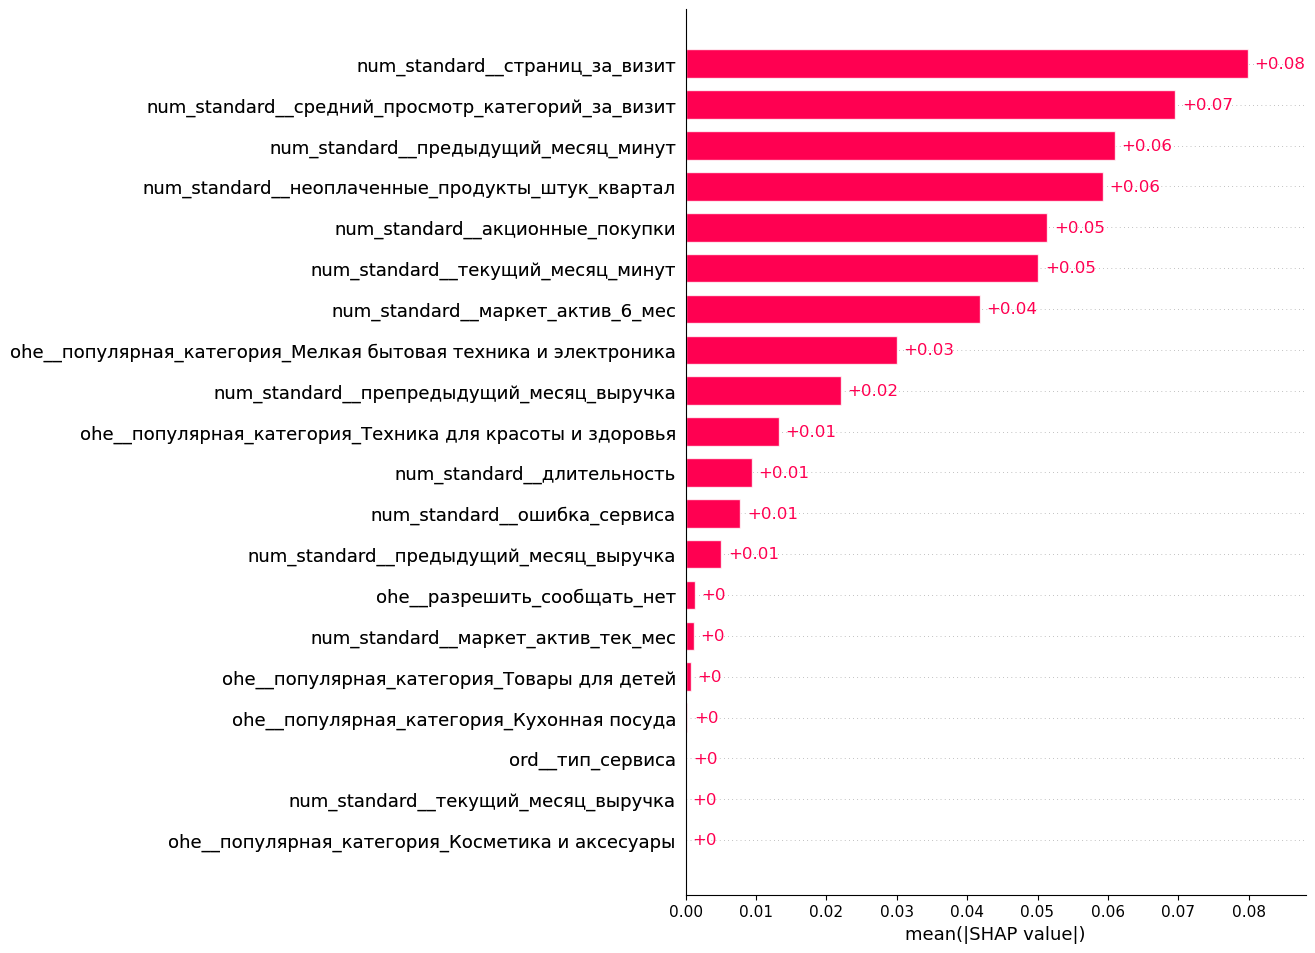

In [74]:
shap.plots.bar(shap_values, show=True, max_display=22)

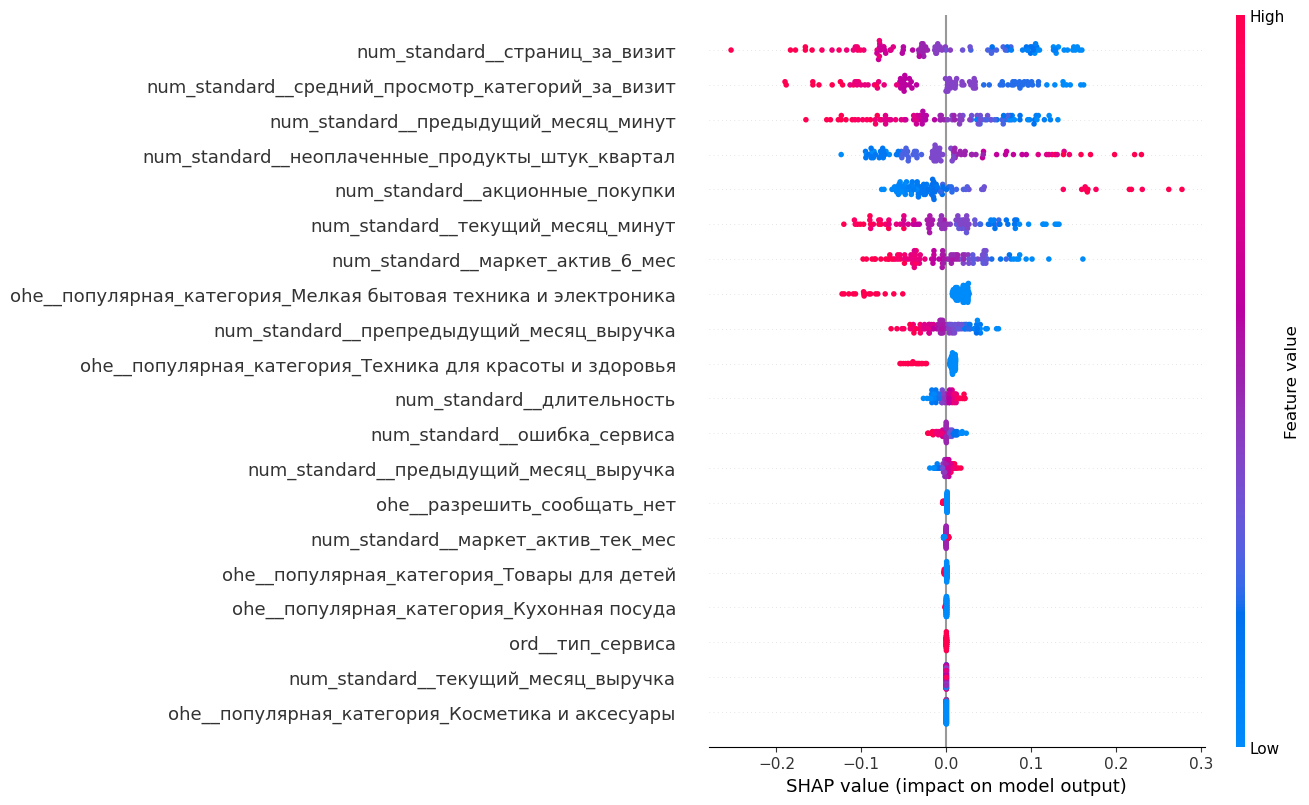

In [75]:
shap.plots.beeswarm(shap_values, show=True, max_display=22)

### Выводы о значимости признаков

#### Мало значимые признаки

1. `ohe__популярная_категория_Кухонная посуда` +0
2. `ord__тип_сервиса` +0
3. `ohe__популярная_категория_Товары для детей` +0
4. `ohe__популярная_категория_Косметика и аксессуары` +0
5. `ohe__разрешить_сообщать_нет` +0
6. `num_standard__маркет_актив_тек_мес` +0
7. `num_standard__текущий_месяц_выручка` +0

Наименее значимых признаков гораздо больше, но мы выделим топ 5 для акцента на наиболее бесполезные из них:
- `текущий_месяц_выручка` - скорее всего этот признак имеет наименьший вес, так как, возможно, текущий период не окончен и точно нет необходимость включать его в признаки для прогнозирования;
- `Кухонная посуда`, `Косметика и аксессуары`, `Товары для детей` - странный показатель, особенно удивляет то, что `Товары для детей` является наиболее популярной категорией в нашем датасете. Возможно это связано с тем, что наша целевая аудитория "вырастила" своих детей и не пользуется этой категорией, возможны также и другие варианты. 
- `маркет_актив_тек_мес`, - также являются наименее значимыми признаками, но вероятнее всего это связано с тем, что текущий период еще не окончен и требуется время для полного сбора данных по нему;
- `период_выручка_препредыдущий_месяц` - данный признак имеет наименьшее влияение потому, что покупательская активность не зависит от препредыдущих месяцев и тех, что были ранее. Необходимо ссылаться лишь на текущий и предыдущий периоды для оценки состояния и стратегии в развитии площадки;
- `тип_сервиса` - интересное наблюдение, оказывается, что подписка никак не сказывается на покуп.способности, возможно это связано с тем, что люди не пользуются ей на постоянной основе, а площдка предоставляет пробный период, либо же подписка не оправдывает ожиданий и люди более не обращаются к площадке. Необходимо собрать больше данных для анализа этого признака;

Также не стоит забывать, что наказание в нашей модели является регуляризация Ласо, которая зануляет менее значимые признаки.

#### Наиболее значимые признаки

1. `num_standard__страниц_за_визит` +0.08
2. `num_standard__средний_просмотр_категорий_за_визит` +0.07
3. `num_standard__предыдущий_месяц_минут` +0.06
4. `num_standard__неоплаченные_продукты_штук_квартал` +0.06
5. `num_standard__акционные_покупки` +0.05
6. `num_standard__текущий_месяц_минут` +0.05

Итак, мы видим, что на модель наибольшим образом влияют 5 первых признаков:
- `средний_просмотр_категорий_за_визит`, `страниц_за_визит`, `предыдщий_месяц_минут` `текущий_месяц_минут`и - наиболее значимые признаки из всех в данном случае. Это может говорить о том, что важность пребывания на площаке наибольшим образом влияет на покупательскую активность. Причем по графику `beeswarm` мы видим, что высокие значения и низкие значения практически строго разделены между положительным (в сторону снижения покуп.актив.) и отрицательным (в сторону сохранения покуп.актив.) влиянием на модель, это говорит нам лишь о том, что с разной степенью силы эти признаки все же линейной влияют на нашу модель, то есть, если показатели выше, то покуп.способ. остается прежней, иначе - снижается;


- `неоплаченные_продукты_штук_квартал` - интересный признак, который зачастую оказывает негативное влияние на покупки, но в отдельных случаях может способствовать положительному предсказанию. Например, если клиент не оплатил продукты ранее, это может означать проблемные транзакции, снижая вероятность будущих покупок. Если ссылаться на график `beeswarm`, то определенно можно сказать, что при более высоких значениях этого показателя покуп.способ. с большей вероятностью снизится, при более низких - прежний уровень.

- `ационные_покупки` - то, что данный признак влияет на нашу модель даже как-то очевидно, ведь люди склонны покупать все подешевле, а ации - инструмент для привлечения внимания, поэтому в исследовательском анализе я дал рекомендацию к пристальному вниманию по поводу акционной политики, но здесь стоит отметить вклад `beeswarm`, а именно то, что низкие значения этого показателя не снижают покуп.актив., в отличие от высоких. Возможно, это говорит нам о том, что есть категория людей, которые покупают товары только по большим скидками, либо есть контенгент покупателей, которые пользуются площадкой, услышав о больших скидках на какой-либо товар в интернет-магазине. Одно друго не исключает;

#### Выводы

##### Средний просмотр категорий за визит, страниц за визит, предыдущий месяц минут, текущий месяц минут

**Выводы**
- Временные метрики, такие как число просмотренных категорий и страниц за визит, количество минут, проведённых на сайте в текущем и предыдущем месяцах, оказывают значительное влияние на покупательскую активность. Высокие значения этих признаков обычно свидетельствуют о сохранении покупательской способности, в то время как низкие значения могут указывать на её снижение.

**Рекомендации**
- Разработайте интерфейс, который будет интуитивно понятным и удобным, чтобы пользователи могли легко находить интересующие их товары.
- Внедрите рекомендационные системы, которые будут предлагать пользователям товары и категории на основе их предыдущих просмотров и покупок.
- Создание и размещение увлекательного контента (например, статей, обзоров товаров, видеороликов), который будет способствовать длительному пребыванию на сайте.
- Применение механизма геймификации, где за активные действия на сайте пользователи будут получать поощрения или скидки.

#### Неоплаченные продукты в штуках за квартал

**Выводы**
- Наличие большого количества неоплаченных продуктов может свидетельствовать о проблемных транзакциях или негативном опыте пользователей, что снижает вероятность будущих покупок. Но в отдельных случаях этот признак может оказать положительное влияние.

**Рекомендации**
- Убедитесь, что процесс оформления заказа и оплаты максимально прост и понятен, чтобы уменьшить количество неоплаченных заказов.
- Активно собирайте и анализируйте обратную связь от пользователей, чтобы понимать причины, по которым пользователи не завершают покупки.
- В случаях проблем с оплатой обеспечьте оперативную поддержку и предложите альтернативные способы расчета.

## Сегментация покупателей

In [76]:
df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,покупательская_активность_num
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,1
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,1


In [77]:
df['покупательская_активность_num_pred'] = best_pipeline.predict(df
                                            .drop(['покупательская_активность',
                                                   'покупательская_активность_num'],
                                                 axis=1))
df['вероятность_понижения'] = best_pipeline.predict_proba(df
                                            .drop(['покупательская_активность',
                                                   'покупательская_активность_num'],
                                                 axis=1))[:, 1]

In [78]:
df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,покупательская_активность_num,покупательская_активность_num_pred,вероятность_понижения
id,,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1,1,0.868282
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,1,0,0.328890
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1,1,0.771319
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1,1,0.947543
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,1,1,0.604088


Соединим наш основной датафрейм с **money**:

In [79]:
money = money.sort_values(by='id').set_index('id')

In [80]:
df_segment = pd.merge(df, money, left_index=True, right_index=True, how='left')
df_segment.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,покупательская_активность_num,покупательская_активность_num_pred,вероятность_понижения,прибыль
id,,,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,...,5,5216.0,4472.0,4971.6,12,10,1,1,0.868282,4160.0
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,...,5,5457.5,4826.0,5058.4,8,13,1,0,0.328890,3130.0
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,...,4,6158.0,4793.0,6610.4,11,13,1,1,0.771319,4870.0
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,...,2,5807.5,4594.0,5872.5,8,11,1,1,0.947543,4210.0
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,...,4,4738.5,5124.0,5388.5,10,10,1,1,0.604088,3950.0


In [81]:
df_segment.прибыль.describe().to_frame()

,прибыль
count,1296.000000
mean,3997.700617
std,1011.198207
min,860.000000
25%,3300.000000
50%,4045.000000
75%,4670.000000
max,7430.000000


Для анализа возьмем группу покупателей, у которых покупательская активность снизилась и прибыльность высокая (выше 3 квантиля), а как контрсегмент возьмем группы со сниженной покуп.актив. и низкой прибыльностью (ниже 1 квантиля):

In [82]:
segment = df_segment.query('прибыль > 4670 and покупательская_активность_num_pred == 1')
contrSegment = df_segment.query('прибыль > 4670 and покупательская_активность_num_pred == 0')
df_general = df_segment.query('прибыль > 4670')

Рассмотрим на распределения по каждому из сегментов: 
Напомним про топ значимых признаков:
1. `страниц_за_визит` +0.08
2. `средний_просмотр_категорий_за_визит` +0.07
3. `предыдущий_месяц_минут` +0.06
4. `неоплаченные_продукты_штук_квартал` +0.06
5. `акционные_покупки` +0.05
6. `текущий_месяц_минут` +0.05

In [83]:
contrSegment.describe() - segment.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,покупательская_активность_num,покупательская_активность_num_pred,вероятность_понижения,прибыль
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.0,117.000000,117.000000
mean,1.004029,-0.181598,9.289762,-0.215569,1.294704,-1.919417,0.818756,5.271403,41.262533,358.607679,-118.233641,5.139497,4.808517,-0.759532,-1.0,-0.702486,1.854810
std,-0.132768,-0.014155,0.967475,-0.153881,0.127890,-0.715712,0.240567,1.278780,-187.393381,47.152481,-55.193778,0.826029,1.345761,-0.037717,0.0,-0.011122,-71.172293
min,1.700000,0.000000,-31.000000,-0.010000,0.000000,0.000000,-1.000000,2.000000,354.000000,220.000000,7.100000,3.000000,0.000000,0.000000,-1.0,-0.505056,0.000000
25%,0.800000,-1.000000,21.250000,-0.082500,1.000000,-1.000000,1.000000,4.000000,224.250000,310.750000,178.125000,4.000000,4.000000,-1.000000,-1.0,-0.713500,-25.000000
50%,0.650000,0.000000,-36.500000,-0.110000,2.000000,-2.000000,1.000000,6.000000,-43.000000,339.000000,-200.800000,5.000000,5.000000,-1.000000,-1.0,-0.791584,80.000000
75%,1.200000,-1.000000,18.750000,-0.150000,2.000000,-2.500000,1.000000,6.000000,-220.750000,449.250000,-345.900000,7.000000,6.000000,-1.000000,-1.0,-0.764212,117.500000
max,1.000000,0.000000,-12.000000,0.000000,0.000000,-5.000000,1.000000,8.000000,132.000000,262.000000,347.000000,5.000000,4.000000,0.000000,-1.0,-0.500012,-410.000000


In [84]:
def scatter_plot(feature, value, hue, df=df):
        if feature not in df.columns or value not in df.columns:
            raise ValueError(f"Один из столбцов: '{feature}' или '{value}' не найден в DataFrame")
        fig, ax = plt.subplots(3, 2, figsize=(20, 15))
        cnt = 0
        fig.suptitle(f'Зависимость значения {value} от {feature}')
        for i, item in enumerate(hue):
            sns.scatterplot(data=df,
                           x=feature,
                           y=value, 
                           hue=item,
                           ax=ax[cnt, i % 2]
                           )
            ax[cnt, i % 2].axvline(x=0.5, color='g', linestyle='-.', linewidth=3)
            ax[cnt, i % 2].set_xlabel(f'Значение переменной {feature}')
            ax[cnt, i % 2].set_ylabel(f'Значение переменной {value}')
            if i % 2:
                cnt += 1
            

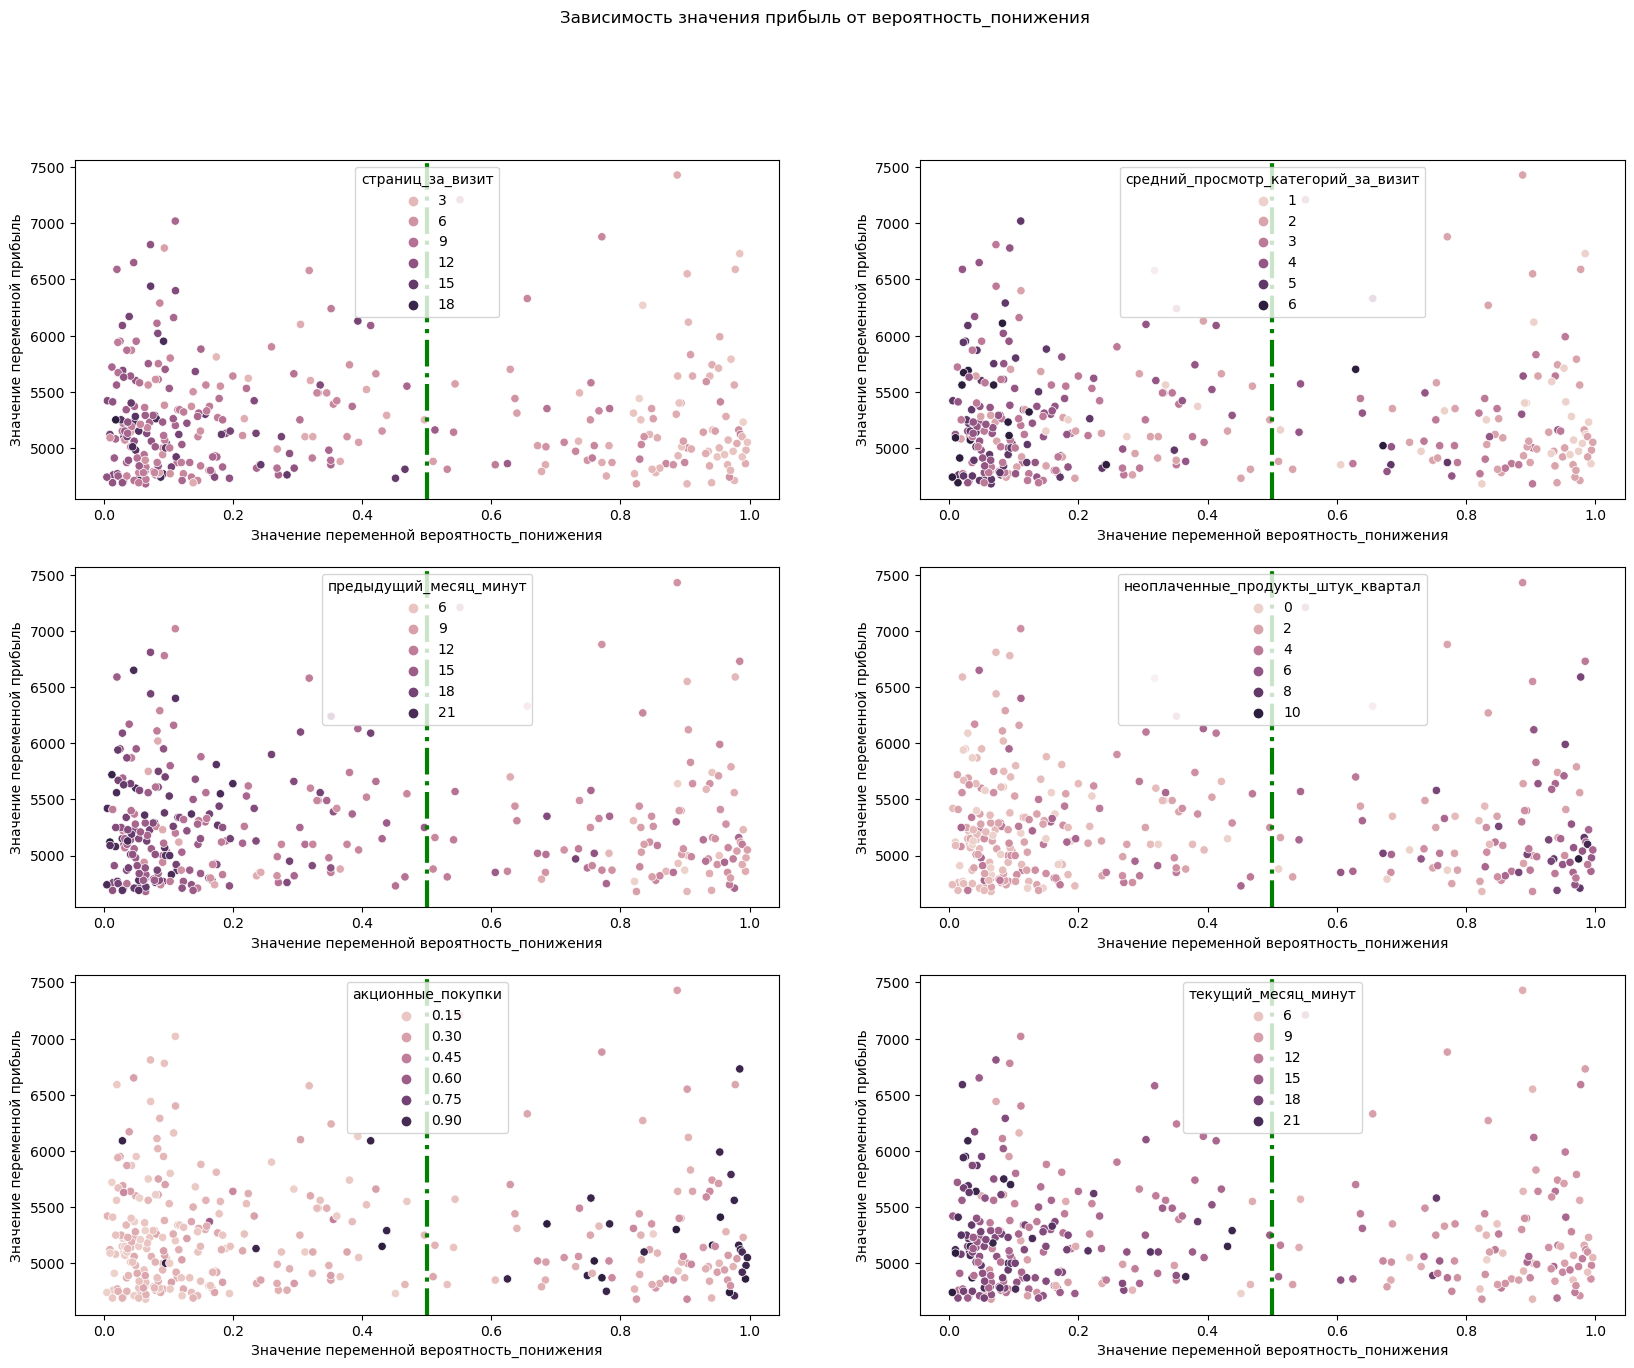

In [85]:
scatter_plot('вероятность_понижения',
                 'прибыль',
                 hue=['страниц_за_визит',
                  'средний_просмотр_категорий_за_визит',
                  'предыдущий_месяц_минут',
                  'неоплаченные_продукты_штук_квартал',
                  'акционные_покупки',
                  'текущий_месяц_минут'],
                 df=df_general)

### Страницы за визит

- **Активность не изменилась:** Эти покупатели просматривают больше страниц за визит.
- **Активность снизилась:** Эти покупатели просматривают меньше страниц за визит.

**Вывод:** Удержание клиентов связано с более активным просмотром сайта, причем те покупатели, которые остаются активными, склонны просматривать больше страниц за один визит.

### Средний просмотр категорий за визит

- **Активность не изменилась:** Эти покупатели просматривают больше категорий за визит.
- **Активность снизилась:** Эти покупатели просматривают меньше категорий за визит.

**Вывод:** Покупатели, чья активность не снизилась, проявляют больший интерес к разнообразию товаров, что может свидетельствовать о более широких интересах или меньшей целенаправленности их поиска.

### Предыдущий месяц (минут)

- **Активность не изменилась:** Эти покупатели проводили больше времени на сайте в предыдущем месяце.
- **Активность снизилась:** Эти покупатели проводили меньше времени на сайте в предыдущем месяце.

**Вывод:** Высокая вовлеченность и частое посещение сайта в предыдущем месяце коррелируют с устойчивой активностью покупателей. 

### Неоплаченные продукты (штук, квартал)

- **Активность не изменилась:** Меньше неоплаченных продуктов за квартал.
- **Активность снизилась:** Больше неоплаченных продуктов за квартал.

**Вывод:** Меньшее количество неоплаченных продуктов может свидетельствовать о более высоком уровне удовлетворенности покупательским опытом или лучшей платежной дисциплине в группе с неизменной активностью.

### Акционные покупки
- **Активность не изменилась:** Частое участие в акциях и распродажах.
- **Активность снизилась:** Редкое участие в акциях.

**Вывод:** Активное участие в акциях связано с устойчивой активностью покупателей. Это может говорить о важности специальных предложений для удержания клиентов.

### Количество продуктов в заказе
- **Активность не изменилась:** Эти покупатели часто делают крупные заказы.
- **Активность снизилась:** Эти покупатели делают менее крупные заказы.

**Вывод:** Более крупные заказы могут указывать на хорошую покупательскую способность или доверие к продуктам и сервису.

### Вывод
На основе анализа данных, мы видим следующие ключевые различия между двумя группами покупателей:

1. Покупатели с неизменной активностью более активно пользуются сайтом, просматривают больше страниц и категорий, а также проводят больше времени на сайте.
2. Покупатели с неизменной активностью имеют меньше неоплаченных продуктов.
3. Покупатели с неизменной активностью чаще участвуют в акциях и распродажах. 
4. Эти покупатели делают более крупные заказы.

## Вывод
### Задачи

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

### Исходные данные и проведённая предобработка

1) - market_file - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- market_money - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- market_time - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- money - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

2) - Был проведен обзор данных, где **не было** выявлено некоторого кол-ва пропусков, что делает данные приятными для работы. В **dataframe** money была проведена обработка признака **Прибыль** и приведение его к корректному виду. Данные в таблицах соответствуют описанию.

3) - В ходе предобработки данных было выявлено не совсем корректное название признаков и впоследствии проблема была решена, выполнена обработка неявных дубликатов. 

### Исследовательский анализ
Был проведен исследовательский анализ по каждому из dataframe, сделаны следующие выводы:

1) **market_file**:
- **Покупательская активность** - Мы видим, что у более 1/3 клиентов покупательская активность снизилась, что достаточно негативно сказывается на общем состоянии компании.
- **Тип сервиса** - Большая часть пользователей составляют люди со стандратной подпиской (71.1%), что значит, что они являются целевой аудиторией, однако немалая часть из общего числа пользователей пользуется премиум подпиской (28.9%). Причем распределение целевого признакак таково, что в процентном соотношении класс людей с премиум подпиской теряет имеет больше человек, имеющих снижение покупательской активности, нежели люди без подписки.
- **Разрешить сообщать** - Как мы видим достаточно большое количество пользователей дало согласие на отправку СМС-сообщений (74%), что говорит о лояльности аудитории к сервису и принятию той информации, которую можно распространят среди них. Причем в процетном соотшении здесь потери по классам примерно одинаковые, что говорит о том, что это признак не сильно влияет на наш целевой признак.
- **Маркет актив 6 месяц** - Как мы видим, компания снизила тенденцию к маркетингу через свою пользовтельскую базу 2 месяца назад, после пика, а также мы наблюдаем достаточно низкий показатели по текущему месяцу. Причем основные потери клиентов происходили в период роста этого показателя;
- **Маркет актив тек мес** - Мы видим, что в текущем месяце с большей частью выборки (51.5%) с точки зрения маркетинга коммуницировали 4 раза, 5 раз с выборкой из 24.8% пользователей, 3 раза с выборкой из 23.7% процентов, причем эти показатели самые низкие за предыдущие два месяца, что говорит нам о том, что в среднем компания еще больше продвигала тои или иной товар.
- **Длительность** - Как мы видим, распределение похоже на нормальное, но с достаточно большой дисперсией, что говорит нам о том, что популряность имела положительную динамику, начиная со старта запуска интернет-магазина, потом прирост был стабильный, но около 400 дней назад динамика достаточно ухудшилась.
- **Акционные покупки** - Диаграмма box_plot указывает на выбросы после примерно 50% скидки, хотя необходимо учесть скидки и посе этого порога, несмотря на перевес левого класса, поэтому оставим как есть.За последние 6 месяцев мы видим, что большинство товаров, которые купили пользователи, находятся в диапозоне от 10% до 40%, а также немаленькая часть выборки попадает на акции от 90% до 100%. Эта информация некоторым образом описывает стратегию и введение акции на конкретные товары в интернет-магазине, то есть наиболее привлекательными является категория товаров, которая попадает в вышеупомянутые диапозоны. Также мы видим небольшую часть выборки со скидкой до 10%, что указывает нам на то, что покупатель не очень желает приобретать товары с такой скидкой. Диапозон от 60% до 80% тоже является почти нулевым сегментом, что говорит нам либо о некорректном подборе товаров со стороны продавца, либо о некорректной скидки для покупателей (требуется больше). При этом всем правый класс скидок показывает нам, что в процентном соотношении на огронмых скидках людей, у которых понизилась покупательская активность, значительно больше противоположного класса.
- **Популярная категория** - Здесь мы видим следующее:
    - Категория `Товары для детей` составляет четверть от всех продаж, что говорит нам о том, что одной из целевой аудиторией являются семьи и их дети.
    - `Домашний текстиль` занимает также одну из ведущих частей нашей выборки (19.3%), что частично ссылает нас на категорию `Товары для детей`. Очень вероятно, что они связаны, ведь в семейной жизни (особенно, когда у Вас маленькие дети) необходимо немалое кол-во, например, пастельного белья или разного вида полотенцев.
    - Оставшиеся категории товаров, а именно `Косметика и аксуссуары`, `Техника для красоты и здоровья`, `Мелкая бытовая техника и электроника`, `Кухонная посуда` также имеют немаленький вклад в общее кол-во продаж, однако тут уже сложно выявлять какие-либо зависимости, необходимы иные исследования.
- **Средний просмотр категорий за визит** - Как мы видим, большая часть выборки (68%) являются просмотрами от 3 до 6 категорий за визит, что говорит нам о наполненности сайта товарами и заинтересованности пользователей. Просмотр 1 и 2 категорий за визит напротив заставляет задуматься о ассортименте, ведь 32% посещений, в течение которых было просмотрено так мало категорий, говорит нам либо о недостаточной наполненности магазина и(или) неграмотной политики ценообразования (были приведены наиболее вероятностные причины).Также мы можем наблюдать тенденцию того, что при малом кол-во просмотров увеличивается и процент и общее кол-во людей со сниженной покупательской способностью.
- **Неоплаченные продукты штук квартал** - Мы видим, что большая часть клиентов содержит в своей коризне от 1 до 6 неоплаченных товаров, по разбиению по покупательской активности мы видим, что с увеличением кол-ва неполаченных товаров в корзине процент людей со сниженной покупательской активностью увеличивается вплоть то 100 процентов, что говорит нам о том, что этот признак не очень хорошо влияет на таргет.
- **Ошибка сервиса** - Распределение этого признака походит на нормальное, немного смещено влево. В целом достаточно неоднозначный признак. Можно сказать только то, что необходимо сместить мат ожидание как можно ближе к нулю :)
- **Страниц за визит** - Интересное наблюдение, а именно мы видим, что 5 страниц за визить подавляющим большинством является клиент с пониженной покупательской активностью, что говорит нам о том, что это один из важнейших признаков, который необходимо рассматривать дальше, причем в boxplot мы видим, что около четверти всех наблюдений находится именно в том месте, где происходит спад активности людей.

2) **market_money**:
- **Выручка (период)** - На box_plot мы видим выбросы, но они связаны с тем, что в текущем месяце больше дисперсия, чем в остальных, поэтому оставим эти выбросы для более удачного обучения модели. Итак, мы имеем 3 периода, а именно текущий месяц, предыдущий и препредыдущий. Ссылаясь на распределение сделаем некоторые выводы:
    - Во всех распределениях наблюдается одинаковое кол-во наблюдений, однако сами распределния значительно различаются;
    - С течением времени мат ожидание находится на приблизительно одинаковом уровне, однако дисперсия увеличивается;
    - В случае с предыдущим месяцем относительно mu += σ большая часть выборки наблюдается с левой стороны, а в текущем периоде наоборот - с правой, что положительно влияет на общее число выручки;
    - Можно предположить, что либо старая аудитория больше стала доверять сервису и покупать все больше товаров, либо наплыв новых пользователей с немного иными ежемесячными тратами повлиял на статистику, но, судя по анализу датафрейма market_file, предпочтительней предположить первый вариант.

3) **market_time**:
- **Минут/Длительность посещений (период)** - Как мы видим, распределение снова нормальное, каких-то существенный различий в посещениях сайта между периодами нет, среднее посещение сайта - 10 - 15 минут.


4) **money**:
- Прибыль также имеет нормальное распределение, ссылаясь на анализ по выручке, можно сказать, что магазин имеет достаточно неплохую наценку на услуги, среденее значение находится в диапозоне 3500 - 5500 рублей.



#### Рекомендации:
- Необходимо пересмотреть акционную политику, ввести более интересные ивенты, при этом не снижать кол-ва акций, ведь люди уже привыкли к ним.
- Ссылаясь на то, что аудитория дает согласие на рассылку сообщений, сделать какие-то вознаграждения в виде бонусов на площадке и усилить маркетинговую стратегию, используя этот и иные способы продвижения.
- Необходимо сделать больший упор на основные категории товаров, а именно на `Товары для детей`, `Домашний текстиль`, расширить ассортимент, ввести большое кол-во акций для продвижения этих категорий. Также стоит обратить внимание на оставшиеся категории.
- Нужно переработать интерфейс сайта или доработать рекомендательные системы для покупателей, таким образом получится увеличить пребывание клиентов на сайте.
- Ввести поощрения для покупателей такиим образом, чтобы товары в корзине не задерживались надолго, например, ввести поощрение в виде дополнительных бонусов, если покупатель оплатит товар в течение некоторого времени после его добавления в корзину.
- Также стоит учесть признак **Ошибка сервиса** и наладить сайт так, чтобы этот признак минимизировать.


### Объединение таблиц

Сделаем объединение таблиц. Для начала объединим таблицы **market_file** и **market_money** для фильтрации пользоватлей по признаку активности за последние 3 месяца, а дальше объединим **market_time**:

#### Рекомендации:
- Необходимо пересмотреть акционную политику, ввести более интересные ивенты, при этом не снижать кол-ва акций, ведь люди уже привыкли к ним.
- Ссылаясь на то, что аудитория дает согласие на рассылку сообщений, сделать какие-то вознаграждения в виде бонусов на площадке и усилить маркетинговую стратегию, используя этот и иные способы продвижения.
- Необходимо сделать больший упор на основные категории товаров, а именно на `Товары для детей`, `Домашний текстиль`, расширить ассортимент, ввести большое кол-во акций для продвижения этих категорий. Также стоит обратить внимание на оставшиеся категории.
- Нужно переработать интерфейс сайта или доработать рекомендательные системы для покупателей, таким образом получится увеличить пребывание клиентов на сайте.
- Ввести поощрения для покупателей такиим образом, чтобы товары в корзине не задерживались надолго, например, ввести поощрение в виде дополнительных бонусов, если покупатель оплатит товар в течение некоторого времени после его добавления в корзину.
- Также стоит учесть признак **Ошибка сервиса** и наладить сайт так, чтобы этот признак минимизировать.

### Корреляционный анализ
Как показал коэффицент корреляции, между признаками **предыдущий_месяц_выручка** и **текущий_месяц_выручка** наблюдается линейная зависимость.

- **Первый график (страниц_за_визит):** Несмотря на различия в количестве страниц за визит, основная зависимость между предыдущей и текущей выручками остается линейной.
  
- **Второй график (предыдущий_месяц_минут):** Длительность времени, проведенного на сайте в предыдущем месяце, также показывает, что чем больше было времени, тем выше выручка как в предыдущем, так и в текущем месяце, что тоже подкрепляет линейную зависимость.

- **Третий график (текущий_месяц_минут):** Здесь наблюдается аналогичная картина: большее количество минут, проведенных на сайте в текущем месяце, связано с более высокой текущей выручкой, но основная линейность зависимостей сохраняется.

- **Четвертый график (покупательская_активность):** Вне зависимости от изменения покупательской активности (снизилась или осталась на прежнем уровне) основная зависимость между значениями выручек также остается на уровне линейности.

Таким образом, предыдущая выручка служит сильным предиктором для определения текущей выручки независимо от исследуемых параметров. Можно предположить, что выручка в предыдущем месяце является основным драйвером текущей выручки.

### Использование пайплайнов
Мы обучили 4 модели (KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC()) и получили наилучшую модель LogisticRegression() с параметрами C=1, penalty='l1' и solver='liblinear'. Значение метрики близко к 1, что можно интерпретировать как очень хороший показатель того, что модель отлично различает классы.

### Shap анализ

#### Выводы о значимости признаков

##### Мало значимые признаки

1. `ohe__популярная_категория_Кухонная посуда` +0
2. `ord__тип_сервиса` +0
3. `ohe__популярная_категория_Товары для детей` +0
4. `ohe__популярная_категория_Косметика и аксессуары` +0
5. `ohe__разрешить_сообщать_нет` +0
6. `num_standard__маркет_актив_тек_мес` +0
7. `num_standard__текущий_месяц_выручка` +0

Наименее значимых признаков гораздо больше, но мы выделим топ 5 для акцента на наиболее бесполезные из них:
- `текущий_месяц_выручка` - скорее всего этот признак имеет наименьший вес, так как, возможно, текущий период не окончен и точно нет необходимость включать его в признаки для прогнозирования;
- `Кухонная посуда`, `Косметика и аксессуары`, `Товары для детей` - странный показатель, особенно удивляет то, что `Товары для детей` является наиболее популярной категорией в нашем датасете. Возможно это связано с тем, что наша целевая аудитория "вырастила" своих детей и не пользуется этой категорией, возможны также и другие варианты. 
- `маркет_актив_тек_мес`, - также являются наименее значимыми признаками, но вероятнее всего это связано с тем, что текущий период еще не окончен и требуется время для полного сбора данных по нему;
- `период_выручка_препредыдущий_месяц` - данный признак имеет наименьшее влияение потому, что покупательская активность не зависит от препредыдущих месяцев и тех, что были ранее. Необходимо ссылаться лишь на текущий и предыдущий периоды для оценки состояния и стратегии в развитии площадки;
- `тип_сервиса` - интересное наблюдение, оказывается, что подписка никак не сказывается на покуп.способности, возможно это связано с тем, что люди не пользуются ей на постоянной основе, а площдка предоставляет пробный период, либо же подписка не оправдывает ожиданий и люди более не обращаются к площадке. Необходимо собрать больше данных для анализа этого признака;

Также не стоит забывать, что наказание в нашей модели является регуляризация Ласо, которая зануляет менее значимые признаки.

##### Наиболее значимые признаки

1. `num_standard__страниц_за_визит` +0.08
2. `num_standard__средний_просмотр_категорий_за_визит` +0.07
3. `num_standard__предыдущий_месяц_минут` +0.06
4. `num_standard__неоплаченные_продукты_штук_квартал` +0.06
5. `num_standard__акционные_покупки` +0.05
6. `num_standard__текущий_месяц_минут` +0.05

Итак, мы видим, что на модель наибольшим образом влияют 5 первых признаков:
- `средний_просмотр_категорий_за_визит`, `страниц_за_визит`, `предыдщий_месяц_минут` `текущий_месяц_минут`и - наиболее значимые признаки из всех в данном случае. Это может говорить о том, что важность пребывания на площаке наибольшим образом влияет на покупательскую активность. Причем по графику `beeswarm` мы видим, что высокие значения и низкие значения практически строго разделены между положительным (в сторону снижения покуп.актив.) и отрицательным (в сторону сохранения покуп.актив.) влиянием на модель, это говорит нам лишь о том, что с разной степенью силы эти признаки все же линейной влияют на нашу модель, то есть, если показатели выше, то покуп.способ. остается прежней, иначе - снижается;


- `неоплаченные_продукты_штук_квартал` - интересный признак, который зачастую оказывает негативное влияние на покупки, но в отдельных случаях может способствовать положительному предсказанию. Например, если клиент не оплатил продукты ранее, это может означать проблемные транзакции, снижая вероятность будущих покупок. Если ссылаться на график `beeswarm`, то определенно можно сказать, что при более высоких значениях этого показателя покуп.способ. с большей вероятностью снизится, при более низких - прежний уровень.

- `ационные_покупки` - то, что данный признак влияет на нашу модель даже как-то очевидно, ведь люди склонны покупать все подешевле, а ации - инструмент для привлечения внимания, поэтому в исследовательском анализе я дал рекомендацию к пристальному вниманию по поводу акционной политики, но здесь стоит отметить вклад `beeswarm`, а именно то, что низкие значения этого показателя не снижают покуп.актив., в отличие от высоких. Возможно, это говорит нам о том, что есть категория людей, которые покупают товары только по большим скидками, либо есть контенгент покупателей, которые пользуются площадкой, услышав о больших скидках на какой-либо товар в интернет-магазине. Одно друго не исключает;

##### Выводы

###### Средний просмотр категорий за визит, страниц за визит, предыдущий месяц минут, текущий месяц минут

**Выводы**
- Временные метрики, такие как число просмотренных категорий и страниц за визит, количество минут, проведённых на сайте в текущем и предыдущем месяцах, оказывают значительное влияние на покупательскую активность. Высокие значения этих признаков обычно свидетельствуют о сохранении покупательской способности, в то время как низкие значения могут указывать на её снижение.

**Рекомендации**
- Разработайте интерфейс, который будет интуитивно понятным и удобным, чтобы пользователи могли легко находить интересующие их товары.
- Внедрите рекомендационные системы, которые будут предлагать пользователям товары и категории на основе их предыдущих просмотров и покупок.
- Создание и размещение увлекательного контента (например, статей, обзоров товаров, видеороликов), который будет способствовать длительному пребыванию на сайте.
- Применение механизма геймификации, где за активные действия на сайте пользователи будут получать поощрения или скидки.

##### Неоплаченные продукты в штуках за квартал

**Выводы**
- Наличие большого количества неоплаченных продуктов может свидетельствовать о проблемных транзакциях или негативном опыте пользователей, что снижает вероятность будущих покупок. Но в отдельных случаях этот признак может оказать положительное влияние.

**Рекомендации**
- Убедитесь, что процесс оформления заказа и оплаты максимально прост и понятен, чтобы уменьшить количество неоплаченных заказов.
- Активно собирайте и анализируйте обратную связь от пользователей, чтобы понимать причины, по которым пользователи не завершают покупки.
- В случаях проблем с оплатой обеспечьте оперативную поддержку и предложите альтернативные способы расчета.

### Сегментация покупателей

#### Страницы за визит

- **Активность не изменилась:** Эти покупатели просматривают больше страниц за визит.
- **Активность снизилась:** Эти покупатели просматривают меньше страниц за визит.

**Вывод:** Удержание клиентов связано с более активным просмотром сайта, причем те покупатели, которые остаются активными, склонны просматривать больше страниц за один визит.

#### Средний просмотр категорий за визит

- **Активность не изменилась:** Эти покупатели просматривают больше категорий за визит.
- **Активность снизилась:** Эти покупатели просматривают меньше категорий за визит.

**Вывод:** Покупатели, чья активность не снизилась, проявляют больший интерес к разнообразию товаров, что может свидетельствовать о более широких интересах или меньшей целенаправленности их поиска.

#### Предыдущий месяц (минут)

- **Активность не изменилась:** Эти покупатели проводили больше времени на сайте в предыдущем месяце.
- **Активность снизилась:** Эти покупатели проводили меньше времени на сайте в предыдущем месяце.

**Вывод:** Высокая вовлеченность и частое посещение сайта в предыдущем месяце коррелируют с устойчивой активностью покупателей. 

#### Неоплаченные продукты (штук, квартал)

- **Активность не изменилась:** Меньше неоплаченных продуктов за квартал.
- **Активность снизилась:** Больше неоплаченных продуктов за квартал.

**Вывод:** Меньшее количество неоплаченных продуктов может свидетельствовать о более высоком уровне удовлетворенности покупательским опытом или лучшей платежной дисциплине в группе с неизменной активностью.

#### Акционные покупки
- **Активность не изменилась:** Частое участие в акциях и распродажах.
- **Активность снизилась:** Редкое участие в акциях.

**Вывод:** Активное участие в акциях связано с устойчивой активностью покупателей. Это может говорить о важности специальных предложений для удержания клиентов.

#### Количество продуктов в заказе
- **Активность не изменилась:** Эти покупатели часто делают крупные заказы.
- **Активность снизилась:** Эти покупатели делают менее крупные заказы.

**Вывод:** Более крупные заказы могут указывать на хорошую покупательскую способность или доверие к продуктам и сервису.

#### Вывод
На основе анализа данных, мы видим следующие ключевые различия между двумя группами покупателей:

1. Покупатели с неизменной активностью более активно пользуются сайтом, просматривают больше страниц и категорий, а также проводят больше времени на сайте.
2. Покупатели с неизменной активностью имеют меньше неоплаченных продуктов.
3. Покупатели с неизменной активностью чаще участвуют в акциях и распродажах. 
4. Эти покупатели делают более крупные заказы.